# 数据预处理

###### 获取色系对应信息

In [ ]:
### https://alexwlchan.net/2019/08/finding-tint-colours-with-k-means/

In [1]:
import collections

from PIL import Image


def get_colors_by_frequency(im):
#     for i in im.getdata():
#         print(i)
    return collections.Counter(im.getdata())


if __name__ == "__main__":
    im = Image.open("2.jpg")
    colors = get_colors_by_frequency(im)
    print(colors.most_common(1))

[((239, 226, 218), 18830)]


(0.7641711757166634, 0.333109475674328, 0.16410854196750993)
#c25429


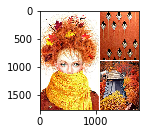

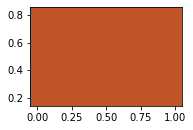

In [4]:
#!/usr/bin/env python
# -*- encoding: utf-8

import colorsys

from PIL import Image
from sklearn.cluster import KMeans
import wcag_contrast_ratio as contrast
import cv2

def get_dominant_colours(path, *, count):
    """
    Return a list of the dominant RGB colours in the image at ``path``.

    :param path: Path to the image file.
    :param count: Number of dominant colours to find.

    """
    im = Image.open(path)

    # Resizing means less pixels to handle, so the *k*-means clustering converges
    # faster.  Small details are lost, but the main details will be preserved.
    im = im.resize((100, 100))

    # Ensure the image is RGB, and use RGB values in [0, 1] for consistency
    # with operations elsewhere.
    im = im.convert("RGB")
    colors = [(r / 255, g / 255, b / 255) for (r, g, b) in im.getdata()]

    return KMeans(n_clusters=count).fit(colors).cluster_centers_


def choose_tint_color(dominant_colors, background_color):
    # The minimum contrast ratio for text and background to meet WCAG AA
    # is 4.5:1, so discard any dominant colours with a lower contrast.
    sufficient_contrast_colors = [
        col
        for col in dominant_colors
        if contrast.rgb(col, background_color) >= 4.5
    ]

    # If none of the dominant colours meet WCAG AA with the background,
    # try again with black and white -- every colour in the RGB space
    # has a contrast ratio of 4.5:1 with at least one of these, so we'll
    # get a tint colour, even if it's not a good one.
    #
    # Note: you could modify the dominant colours until one of them
    # has sufficient contrast, but that's omitted here because it adds
    # a lot of complexity for a relatively unusual case.
    if not sufficient_contrast_colors:
        return choose_tint_color(
            dominant_colors=dominant_colors + [(0, 0, 0), (1, 1, 1)],
            background_color=background_color
        )

    # Of the colours with sufficient contrast, pick the one with the
    # closest brightness (in the HSV colour space) to the background
    # colour.  This means we don't get very dark or very light colours,
    # but more bright, vibrant colours.
    hsv_background = colorsys.rgb_to_hsv(*background_color)
    hsv_candidates = {
        tuple(rgb_col): colorsys.rgb_to_hsv(*rgb_col)
        for rgb_col in sufficient_contrast_colors
    }

    candidates_by_brightness_diff = {
        rgb_col: abs(hsv_col[2] - hsv_background[2])
        for rgb_col, hsv_col in hsv_candidates.items()
    }

    rgb_choice, _ = min(
        candidates_by_brightness_diff.items(),
        key=lambda t: t[1]
    )

    assert rgb_choice in dominant_colors
    return rgb_choice


if __name__ == "__main__":
    import sys

    path = "1.jpg"

    dominant_colors = get_dominant_colours(path, count=5)
    
    image_src = cv2.imread(path)
    image1 = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)

    tint_color = choose_tint_color(dominant_colors, background_color=(0, 0, 0))
    hex_color = "#%02x%02x%02x" % tuple(int(v * 255) for v in tint_color)
    print(tint_color)
    print(hex_color)
    
    import matplotlib.pyplot as plt
    plt.subplot(2, 1, 1)
    plt.imshow(image1)
    plt.show()
    
    plt.subplot(2, 2, 1)
    
    plt.axis('equal')
    ax = plt.gca()
    disk1 = plt.Circle((0, 0), 2, color=hex_color, fill=True)
    ax.add_artist(disk1)
    plt.show()
    
    
    ####### 区域仍然有问题
    

In [5]:
import os,webcolors
import json
from collections import defaultdict

In [6]:

names_dict = {"棕色系": "BrownSeries",
                      "橙色系": "OrangeSeries",
                      "灰色系": "GraySeries",
                      "粉色系": "PinkSeries",
                      "紫色系": "PurpleSeries",
                      "红色系": "RedSeries",
                      "绿色系": "GreenSeries",
                      "蓝色系": "BlueSeries",
                      "黄色系": "YellowSeries"  }

###### 二维字典

def color_collocation_dict(color_root= "./color9_new"):
    dic = {} #defaultdict(dict)
    for color_collocation in os.listdir(color_root):
        #print("文件夹：{}， 色系名称：{}".format(color_collocation,names_dict[color_collocation]) )
        color_dir = os.path.join(color_root,color_collocation)
        #dic[names_dict[color_collocation]] = [color_name for color_name in os.listdir(color_dir)]
            
        dic[names_dict[color_collocation]] = {}
            
        for color_name in os.listdir(color_dir):
            case_path = os.path.join(color_dir, color_name)
            dic[names_dict[color_collocation]][color_name] = [color_case for color_case in os.listdir(case_path)]
            
            
    #print(dic)
    
    return dic
            


color_cases_dict = color_collocation_dict()

In [7]:
####### 读取颜色信息：

def load_colour_json(json_file = "./colors.json"):
    color_dict = {}
    
    def hex2rgb(hex):
        r = int(hex[1:3],16)
        g = int(hex[3:5],16)
        b = int(hex[5:7], 16)
        #rgb = str(r)+','+str(g)+','+str(b)
        rgb = (r,g,b)
        return rgb

    with open(json_file,"r") as f:
        json_dict = json.load(f)
        f.close()
        # print(json_dict)
        
        for ele in json_dict:
            info = json_dict.get(ele)
            c_code = info['编码']
            c_hex = info['RGB值']
            c_name = info['名字']
            c_rgb = hex2rgb(c_hex)
            #print(c_rgb[1])
            #print("key = {}, value = {}".format(ele, info))
            
            color_dict[c_name] = {'name_cn': c_name, 'raw_code':c_code, 'rbg_hex':c_hex, "rgb_value":c_rgb}
            
    
    #print(color_dict)
    
    return color_dict
            
color_infos = load_colour_json()

In [8]:
color_infos

{'Tiffany蓝': {'name_cn': 'Tiffany蓝',
  'raw_code': 'BU 6-01',
  'rbg_hex': '#85dbd8',
  'rgb_value': (133, 219, 216)},
 '丁香灰': {'name_cn': '丁香灰',
  'raw_code': 'GY 3-03',
  'rbg_hex': '#9896a4',
  'rgb_value': (152, 150, 164)},
 '万年青色': {'name_cn': '万年青色',
  'raw_code': 'GN 1-07',
  'rbg_hex': '#155d4f',
  'rgb_value': (21, 93, 79)},
 '中国红': {'name_cn': '中国红',
  'raw_code': 'RD 3-02',
  'rbg_hex': '#be2238',
  'rgb_value': (190, 34, 56)},
 '云灰色': {'name_cn': '云灰色',
  'raw_code': 'GY 3-02',
  'rbg_hex': '#b8a9ae',
  'rgb_value': (184, 169, 174)},
 '亮白色': {'name_cn': '亮白色',
  'raw_code': 'GY 1-01',
  'rbg_hex': '#f2f2f2',
  'rgb_value': (242, 242, 242)},
 '代尔夫特蓝': {'name_cn': '代尔夫特蓝',
  'raw_code': 'BU 2-06',
  'rbg_hex': '#3a5b8e',
  'rgb_value': (58, 91, 142)},
 '佩斯利紫': {'name_cn': '佩斯利紫',
  'raw_code': 'PL 3-03',
  'rbg_hex': '#8977b3',
  'rgb_value': (137, 119, 179)},
 '兰花紫': {'name_cn': '兰花紫',
  'raw_code': 'PL 1-05',
  'rbg_hex': '#b263a4',
  'rgb_value': (178, 99, 164)},
 '冰咖啡色': 

In [8]:
color_cases_dict

{'BlueSeries': {'Tiffany蓝': ['为爱而生',
   '夏日清泉',
   '夹心马卡龙',
   '幸福小女人',
   '怦然心动',
   '最浪漫的事',
   '最长情的告白',
   '浪漫礼物',
   '激情的夏日海滩',
   '爱情箴言',
   '爱的初心',
   '追忆似水年华',
   '青春乐章'],
  '代尔夫特蓝': ['倾泻的月光',
   '冷烟火',
   '前尘旧梦',
   '名利场',
   '大地之语',
   '奢侈品的诱惑',
   '明媚春光',
   '春日回旋舞曲',
   '法式田园风',
   '浪漫青花语',
   '热土',
   '热带童话',
   '爱的祝福',
   '理想之家',
   '田园橙意',
   '盛放的矢车菊',
   '简约蓝调',
   '自然质感',
   '花涧溪',
   '蓝色狙击洛可可',
   '诗意栖居',
   '遇见圣托里尼',
   '青花魅力',
   '飒爽清秋'],
  '勿忘我蓝': ['亲和都市风', '天鹅湖圆舞曲', '晨露', '爱丽丝梦游仙境', '都市恋歌', '静看花开花落'],
  '婴儿蓝': ['冷暖人生',
   '冷烟火',
   '咖啡牛奶糖',
   '四季旋律',
   '夏日田野',
   '天鹅湖圆舞曲',
   '奇妙色彩',
   '女王的水晶宫',
   '宁静田园',
   '斑驳绿影',
   '浅水湾',
   '浪漫棕榈滩',
   '海角之花',
   '热带童话',
   '纯净的浪漫表达',
   '纯真天使',
   '自然食味',
   '飒爽清秋'],
  '孔雀蓝': ['优雅伴侣',
   '俘虏骄傲的心',
   '倾泻的月光',
   '冰雪奇缘',
   '冷暖的优雅',
   '初冬的暖意',
   '古城下的飞鸟',
   '多瑙河的眷恋',
   '大自然的告白',
   '性感古典派',
   '捧在手心的爱',
   '摩洛哥的异域风情',
   '摩登绅士',
   '时尚新中式',
   '星海之谜',
   '春色撩人',
   '权力诱惑',
   '枫林停晚',
   '洛里昂的下午茶',
   '深水幽兰',
   '灵动风尚'

In [9]:
names_dict2= dict([names_dict[ele], ele] for ele in names_dict)
names_dict2

{'BlueSeries': '蓝色系',
 'BrownSeries': '棕色系',
 'GraySeries': '灰色系',
 'GreenSeries': '绿色系',
 'OrangeSeries': '橙色系',
 'PinkSeries': '粉色系',
 'PurpleSeries': '紫色系',
 'RedSeries': '红色系',
 'YellowSeries': '黄色系'}

In [10]:
collocation_dict = {}

for case in color_cases_dict:
    #print("{}, {} \n".format(case,color_cases_dict[case] ))
    
    color_names = list(sorted([i for i in color_cases_dict[case].keys()]))
    color_data = [ color_infos[name]  for i,name in enumerate(color_names) ]
    
    collocation_dict[case] = {
        "collocation": case,
        "name": names_dict2[case],
        "color_names": color_names,
        "color_data": color_data  
        
    }
    #print("色系：{} ，颜色：{}, {}\n".format(case, color_names,color_date))
    
print(collocation_dict)
    

{'BrownSeries': {'collocation': 'BrownSeries', 'name': '棕色系', 'color_names': ['冰咖啡色', '古巴砂色', '太妃糖色', '安道尔棕', '小麦色', '巧克力棕', '曙光银', '月光色', '杏仁色', '栗色', '沙色', '淡金色', '深灰褐色', '灰泥色', '灰褐色', '烤杏仁色', '玳瑁色', '画眉鸟棕', '百灵鸟色', '米褐色', '苦巧克力色', '貂皮色', '金峰石色', '金棕色', '香薰色', '驼色', '鹧鸪色', '黏土色'], 'color_data': [{'name_cn': '冰咖啡色', 'raw_code': 'BN 3-04', 'rbg_hex': '#b18f6a', 'rgb_value': (177, 143, 106)}, {'name_cn': '古巴砂色', 'raw_code': 'BN 3-03', 'rbg_hex': '#c4a98e', 'rgb_value': (196, 169, 142)}, {'name_cn': '太妃糖色', 'raw_code': 'BN 2-06', 'rbg_hex': '#c69b64', 'rgb_value': (198, 155, 100)}, {'name_cn': '安道尔棕', 'raw_code': 'BN 6-02', 'rbg_hex': '#62393d', 'rgb_value': (98, 57, 61)}, {'name_cn': '小麦色', 'raw_code': 'BN 4-01', 'rbg_hex': '#e4c7a7', 'rgb_value': (228, 199, 167)}, {'name_cn': '巧克力棕', 'raw_code': 'BN 4-09', 'rbg_hex': '#443731', 'rgb_value': (68, 55, 49)}, {'name_cn': '曙光银', 'raw_code': 'BN 2-04', 'rbg_hex': '#c0baae', 'rgb_value': (192, 186, 174)}, {'name_cn': '月光色', 'raw_code': 'BN 4-

In [11]:
collocation_dict

{'BlueSeries': {'collocation': 'BlueSeries',
  'color_data': [{'name_cn': 'Tiffany蓝',
    'raw_code': 'BU 6-01',
    'rbg_hex': '#85dbd8',
    'rgb_value': (133, 219, 216)},
   {'name_cn': '代尔夫特蓝',
    'raw_code': 'BU 2-06',
    'rbg_hex': '#3a5b8e',
    'rgb_value': (58, 91, 142)},
   {'name_cn': '勿忘我蓝',
    'raw_code': 'BU 3-01',
    'rbg_hex': '#8eafc2',
    'rgb_value': (142, 175, 194)},
   {'name_cn': '婴儿蓝',
    'raw_code': 'BU 2-01',
    'rbg_hex': '#b7cad9',
    'rgb_value': (183, 202, 217)},
   {'name_cn': '孔雀蓝',
    'raw_code': 'BU 5-05',
    'rbg_hex': '#007d93',
    'rgb_value': (0, 125, 147)},
   {'name_cn': '宁静蓝',
    'raw_code': 'BU 2-03',
    'rbg_hex': '#91a8d1',
    'rgb_value': (145, 168, 209)},
   {'name_cn': '挪威蓝',
    'raw_code': 'BU 4-02',
    'rbg_hex': '#4fa9cc',
    'rgb_value': (79, 169, 204)},
   {'name_cn': '摩洛哥蓝',
    'raw_code': 'BU 4-05',
    'rbg_hex': '#1c4f6a',
    'rgb_value': (28, 79, 106)},
   {'name_cn': '景泰蓝',
    'raw_code': 'BU 4-03',
    'rbg_h

In [12]:
#json.dump(collocation_dict, open("./colour_index.json", 'w', encoding='utf-8'), ensure_ascii=False, indent=4)

In [13]:
#json.dump(collocation_dict, open("./ColourIndex.json.json", 'w'), ensure_ascii=False, indent=4)

In [20]:
########## 加载颜色图信息：


### 读取居其家居颜色信息表
file = open("./ColourIndex.json", "r")
DICT = json.load(file)
file.close()

colorname2rgb = [(ele["name_cn"], ele["rgb_value"])   for K,V in DICT.items()  for ele in V['color_data']]


Colorname2RGB = dict([ele[0],tuple(ele[1])] for ele in colorname2rgb)

In [24]:
import webcolors


hexnames = webcolors.css3_hex_to_names #webcolors.CSS3_HEX_TO_NAMES #webcolors.css3_hex_to_names
hexnames

{'#000000': 'black',
 '#000080': 'navy',
 '#00008b': 'darkblue',
 '#0000cd': 'mediumblue',
 '#0000ff': 'blue',
 '#006400': 'darkgreen',
 '#008000': 'green',
 '#008080': 'teal',
 '#008b8b': 'darkcyan',
 '#00bfff': 'deepskyblue',
 '#00ced1': 'darkturquoise',
 '#00fa9a': 'mediumspringgreen',
 '#00ff00': 'lime',
 '#00ff7f': 'springgreen',
 '#00ffff': 'cyan',
 '#191970': 'midnightblue',
 '#1e90ff': 'dodgerblue',
 '#20b2aa': 'lightseagreen',
 '#228b22': 'forestgreen',
 '#2e8b57': 'seagreen',
 '#2f4f4f': 'darkslategrey',
 '#32cd32': 'limegreen',
 '#3cb371': 'mediumseagreen',
 '#40e0d0': 'turquoise',
 '#4169e1': 'royalblue',
 '#4682b4': 'steelblue',
 '#483d8b': 'darkslateblue',
 '#48d1cc': 'mediumturquoise',
 '#4b0082': 'indigo',
 '#556b2f': 'darkolivegreen',
 '#5f9ea0': 'cadetblue',
 '#6495ed': 'cornflowerblue',
 '#66cdaa': 'mediumaquamarine',
 '#696969': 'dimgrey',
 '#6a5acd': 'slateblue',
 '#6b8e23': 'olivedrab',
 '#708090': 'slategrey',
 '#778899': 'lightslategrey',
 '#7b68ee': 'mediumslat

In [23]:
names = []
colors = []
from scipy.spatial import KDTree

for name_cn, color_rgb in colorname2rgb.items():
        names.append(name_cn)
        colors.append(color_rgb)

spacedb = KDTree(colors)

AttributeError: 'list' object has no attribute 'items'

In [109]:
requested_rgb_colour = (177, 143, 106)
dist, index = spacedb.query(requested_rgb_colour)
closest_name = names[index]
min_dist = dist
closest_name

'冰咖啡色'

In [121]:
import webcolors

def mapping_to_closest_colour(requested_rgb_colour):
    ### rgb空间中的欧几里得距离进行匹配
    hexnames = webcolors.css3_hex_to_names #webcolors.CSS3_HEX_TO_NAMES #webcolors.css3_hex_to_names
    names = []
    colors = []

    for hex, name in hexnames.items():
        names.append(name)
        colors.append(webcolors.hex_to_rgb(hex))
    spacedb = KDTree(colors)

    dist, index = spacedb.query(requested_rgb_colour)
    min_dist = dist
    closest_name = names[index]

    return min_dist, closest_name


In [122]:
from scipy.spatial import KDTree

color2collocation = [(ele["name_cn"], K)   for K,V in DICT.items()  for ele in V['color_data']]
Color2Collocation = dict([ele[0],ele[1]] for ele in color2collocation)

colorname2rgb = [(ele["name_cn"], ele["rgb_value"])   for K,V in DICT.items()  for ele in V['color_data']]
Colorname2RGB = dict([ele[0],tuple(ele[1])] for ele in colorname2rgb)


def mapping_to_closest_colour2(requested_rgb_colour):  
    names = []
    colors = []

    for name_cn, color_rgb in Colorname2RGB.items():
        names.append(name_cn)
        colors.append(color_rgb)
        
    spacedb = KDTree(colors)
    dist, index = spacedb.query(requested_rgb_colour)
    min_dist = dist
    closest_name = names[index]
    print("最近rgb:", colors[index])
    return min_dist, closest_name


In [126]:

requested_rgb_colour = (0,0,0)
min_dist,closet_name = mapping_to_closest_colour2(requested_rgb_colour)

print(min_dist,closet_name)
print(Color2Collocation[closet_name])

最近rgb: (21, 26, 30)
44.91102314577124 纯黑色
GraySeries


In [25]:


def mapping_to_closest_colour2(requested_rgb_colour):
    
    ###### 映射据其家居颜色
    cn_names, cn_colors = [], []
    for name_cn, color_rgb in Colorname2RGB.items():
        cn_names.append(name_cn)
        cn_colors.append(color_rgb)
    
    hexnames = webcolors.css3_hex_to_names  # webcolors.CSS3_HEX_TO_NAMES
    names, colors = [], []
    for wb_hex, wb_name in hexnames.items():
        names.append(wb_name)
        colors.append(webcolors.hex_to_rgb(wb_hex))
    
    
    cn_spacedb = KDTree(cn_colors)
    cn_dist, cn_index = cn_spacedb.query(requested_rgb_colour)
    min_dist = cn_dist
    closest_cn_name = cn_names[cn_index]
    closest_rgb = cn_colors[cn_index]
    

    
    wb_spacedb = KDTree(colors)
    wb_dist, wb_index = wb_spacedb.query(closest_rgb)
    closest_en_name = names[wb_index]
    closest_rgb_wb = colors[wb_index]
    
    print(closest_en_name)
    print(closest_rgb_wb)
    return min_dist, closest_en_name,closest_cn_name


requested_rgb_colour = (25,78,69)
print(mapping_to_closest_colour2(requested_rgb_colour))

darkslategrey
(47, 79, 79)
(12.24744871391589, 'darkslategrey', '深青色')


In [26]:
############# rgb 颜色聚类
import cv2,os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter



imgfile = "1.jpg"
im = cv2.imread(imgfile)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image = im
#plt.imshow(image)
#plt.show()




In [27]:
number_of_colors = 5

modified_image = image
modified_image = modified_image.reshape(modified_image.shape[0] * modified_image.shape[1], 3)
clf = KMeans(n_clusters = number_of_colors)
labels = clf.fit_predict(modified_image)

In [28]:
# labels.tolist()
counts = Counter(labels)
counts = dict(sorted(counts.items()))  ### 排序
center_colors = clf.cluster_centers_
counts

{0: 788615, 1: 716367, 2: 775772, 3: 279724, 4: 579506}

In [29]:
my_counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)##### 键值排序，降序排列
cluster_indexs = [ele[0] for ele in my_counts] ###聚类索引排序
cluster_indexs

[0, 2, 1, 4, 3]

In [47]:
my_counts

[(0, 785782), (4, 777232), (1, 717222), (3, 580643), (2, 279105)]

In [49]:
cluster_nums = [ele[-1] for ele in my_counts] ###聚类计数结果排序
cluster_nums

[785782, 777232, 717222, 580643, 279105]

In [54]:
cluster_rate = ["{:.2f}".format(i/sum(cluster_nums)) for i in cluster_nums]
cluster_rate

['0.25', '0.25', '0.23', '0.18', '0.09']

In [42]:
center_colors

array([[166.9169556 ,  62.20252832,  30.47493219],
       [249.37050427, 244.48724925, 235.56054535],
       [ 62.67893111,  26.90682729,  24.17607809],
       [235.40505966, 198.45799617,  99.82758639],
       [222.83035836, 117.24398841,  51.48083689]])

In [46]:
[(tuple(center_colors[i])) for i in counts]

[(166.91695560170712, 62.20252831735051, 30.47493218550744),
 (249.3705042733746, 244.48724924750667, 235.56054534570222),
 (62.67893111297823, 26.906827291588684, 24.176078087661395),
 (235.40505966271422, 198.45799616597984, 99.827586385772),
 (222.83035836294553, 117.2439884111219, 51.48083689287851)]

In [51]:
rgb_colors = [(tuple(map(int, center_colors[i]))) for i in cluster_indexs]
rgb_colors

[(166, 62, 30), (222, 117, 51), (249, 244, 235), (235, 198, 99), (62, 26, 24)]

In [59]:
##### 转化16进制
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

hex_colors = [RGB2HEX(i) for i in rgb_colors]
hex_colors

['#a63e1e', '#de7533', '#f9f4eb', '#ebc663', '#3e1a18']

In [58]:

cluster_indexs       

[0, 4, 1, 3, 2]

In [64]:
hex_rank

{'#3c1a18': '0.09',
 '#a43d1d': '0.24',
 '#dd7232': '0.25',
 '#ebc562': '0.19',
 '#f9f4eb': '0.23'}

In [59]:
a = [i for i in counts]

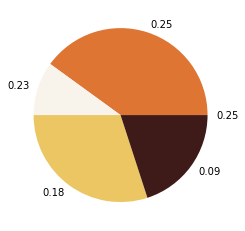

In [57]:
plt.pie(cluster_indexs, labels=cluster_rate, colors = hex_colors)
plt.show()

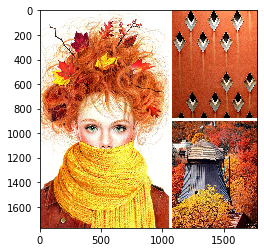

In [56]:
plt.imshow(image)
plt.show()

In [30]:
########################## 图像颜色聚类: 将颜色映射到居其家居的189种

import os,json, cv2
import webcolors
import numpy as np
from scipy.spatial import KDTree
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter



### 读取居其家居颜色信息表
file = open("./ColourIndex.json", "r")
DICT = json.load(file)
file.close()



In [31]:
colorname2rgb = [(ele["name_cn"], ele["rgb_value"])   for K,V in DICT.items()  for ele in V['color_data']]
Colorname2RGB = dict([ele[0],tuple(ele[1])] for ele in colorname2rgb)

color2collocation = [(ele["name_cn"], K)   for K,V in DICT.items()  for ele in V['color_data']]
Color2Collocation = dict([ele[0],ele[1]] for ele in color2collocation)

WEB_DICT = webcolors.css3_hex_to_names # webcolors.CSS3_HEX_TO_NAMES

In [32]:
def dict_index(dict_to_use):
    names, colors = [],[]
    
    if dict_to_use == WEB_DICT:
        for wb_hex, wb_name in dict_to_use.items():
            names.append(wb_name)
            colors.append(webcolors.hex_to_rgb(wb_hex)) 
            #print(wb_hex)
    else:
        for name, color in dict_to_use.items():
            names.append(name)
            colors.append(color)
    
    return names, colors

In [33]:
CN_NAMES, CN_COLOURS = dict_index(Colorname2RGB)
EN_NAMES, EN_COLOURS = dict_index(WEB_DICT)


In [34]:
CN_SPACEDB = KDTree(CN_COLOURS)
WB_SPACEDB = KDTree(EN_COLOURS)

In [35]:
### 将rgb颜色值转化位颜色名称

def colour_name_mapping(requested_rgb_colour):
    #### 居其家居颜色匹配，获取中文名称
    cn_dist, cn_index = CN_SPACEDB.query(requested_rgb_colour)
    closest_cn_name = CN_NAMES[cn_index]
    closest_cn_rgb = CN_COLOURS[cn_index] ### 匹配后的最邻近rgb颜色
    closest_rgb = closest_cn_rgb #### 将匹配到的居其家居最邻近颜色映射到webcolors，获取颜色英文名称
    
    #### 获取颜色英文名称
    try:
        closest_en_name = webcolors.rgb_to_name(closest_rgb)
    except ValueError:
        wb_dist, wb_index = WB_SPACEDB.query(closest_rgb)
        closest_en_name = EN_NAMES[wb_index]
        #closest_wb_rgb = EN_COLOURS[wb_index]
    
    return closest_en_name, closest_cn_name, closest_rgb, cn_dist ### 返回最邻近颜色英文名称，最邻近颜色中文名称（居其家居），最邻近颜色rgb及距离

    

In [36]:
COLOR_COLLOCATION = {
        'BlueSeries': '蓝色系',
         'BrownSeries': '棕色系',
         'GraySeries': '灰色系',
         'GreenSeries': '绿色系',
         'OrangeSeries': '橙色系',
         'PinkSeries': '粉色系',
         'PurpleSeries': '紫色系',
         'RedSeries': '红色系',
         'YellowSeries': '黄色系'
        }


In [37]:
##### 图像颜色聚类,大图


def image_colour_cluster(image, k = 5):
    
    #### 原图缩放，提高速度
    resize_rate = 0.2
    w, h, c = image.shape
    H = int(resize_rate * h) if int(resize_rate * h) > 0 else h
    W = int(resize_rate * w) if int(resize_rate * w) > 0 else w
    modified_image = cv2.resize(image, (H, W), interpolation=cv2.INTER_AREA)
    # modified_image = image
    modified_image = modified_image.reshape(modified_image.shape[0] * modified_image.shape[1], 3)
    
    
    def RGB2HEX(color):##### 颜色转化
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))
    
    #### 图像聚类
    clf = KMeans(n_clusters = k)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    center_colors = clf.cluster_centers_
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)  ##### 键值降序排列
    
    cluster_indexs = [ele[0] for ele in sorted_counts]  ###聚类索引排序
    #cluster_nums = [ele[-1] for ele in sorted_counts]  ###聚类计数结果排序
    cluster_colors = [(tuple(map(int, center_colors[i]))) for i in cluster_indexs] #### 聚类rgb颜色值(排序后)
    cluster_hex_colors = [RGB2HEX(i) for i in cluster_colors] #### 聚类16位rgb颜色(排序后)
    cluster_names = [(colour_name_mapping(i)[:2])  for i in cluster_colors] #### rgb颜色名称[（英文，中文）]
    cluster_percentage = [ele[-1]/sum(counts.values()) for ele in sorted_counts] #### 颜色占比（排序后）
    cluster_collocation = [Color2Collocation[ele[-1]] for ele in cluster_names] ### 颜色色系，映射到居其家居
    cluster_collocation = [(i, COLOR_COLLOCATION[i]) for i in cluster_collocation] 
    #print(cluster_collocation)
    
    
    Result = {
        "k": k,
        "sorted_counts": sorted_counts,
        "sorted_rgb": cluster_colors,
        "sorted_hex": cluster_hex_colors,
        "sorted_names": cluster_names,
        "rgb_percentage": cluster_percentage,
        "cluster_collocation": cluster_collocation
        }
    
    
    return Result


imgfile = "4.jpg"
im = cv2.imread(imgfile)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image = im

Result = image_colour_cluster(image, k = 5)

In [38]:
Result

{'cluster_collocation': [('PinkSeries', '粉色系'),
  ('BrownSeries', '棕色系'),
  ('RedSeries', '红色系'),
  ('RedSeries', '红色系'),
  ('BrownSeries', '棕色系')],
 'k': 5,
 'rgb_percentage': [0.28042099192618225,
  0.27353662053056516,
  0.19096020761245674,
  0.15574538638985005,
  0.0993367935409458],
 'sorted_counts': [(0, 7780), (3, 7589), (2, 5298), (1, 4321), (4, 2756)],
 'sorted_hex': ['#f2e4de', '#debcab', '#c28464', '#a6412c', '#412929'],
 'sorted_names': [('antiquewhite', '奶油粉'),
  ('wheat', '小麦色'),
  ('rosybrown', '沙漠红'),
  ('brown', '庞贝红'),
  ('darkslategrey', '巧克力棕')],
 'sorted_rgb': [(242, 228, 222),
  (222, 188, 171),
  (194, 132, 100),
  (166, 65, 44),
  (65, 41, 41)]}

In [39]:
for i,index in enumerate(Result["sorted_counts"]):

    log = "top {}, index = {}, rgb = {}, hex = {}, 颜色：{}， percentage = {}".format(i, index[0], Result['sorted_rgb'][i], Result["sorted_hex"][i], Result['sorted_names'][i], Result["rgb_percentage"][i])
    print("sort: ", log)

sort:  top 0, index = 0, rgb = (242, 228, 222), hex = #f2e4de, 颜色：('antiquewhite', '奶油粉')， percentage = 0.28042099192618225
sort:  top 1, index = 3, rgb = (222, 188, 171), hex = #debcab, 颜色：('wheat', '小麦色')， percentage = 0.27353662053056516
sort:  top 2, index = 2, rgb = (194, 132, 100), hex = #c28464, 颜色：('rosybrown', '沙漠红')， percentage = 0.19096020761245674
sort:  top 3, index = 1, rgb = (166, 65, 44), hex = #a6412c, 颜色：('brown', '庞贝红')， percentage = 0.15574538638985005
sort:  top 4, index = 4, rgb = (65, 41, 41), hex = #412929, 颜色：('darkslategrey', '巧克力棕')， percentage = 0.0993367935409458


In [40]:
Cluster_names = Result["sorted_names"]
Cluster_percentage = Result["rgb_percentage"]
Cluster_indexs = [ele[0] for ele in Result["sorted_counts"]]
Cluster_hex = Result["sorted_hex"]

In [41]:
LabelsShow = ["{}_{}({:.2f})".format(label, Cluster_names[i],Cluster_percentage[i]) for i, label in enumerate(Cluster_indexs)]
LabelsShow

["0_('antiquewhite', '奶油粉')(0.28)",
 "3_('wheat', '小麦色')(0.27)",
 "2_('rosybrown', '沙漠红')(0.19)",
 "1_('brown', '庞贝红')(0.16)",
 "4_('darkslategrey', '巧克力棕')(0.10)"]

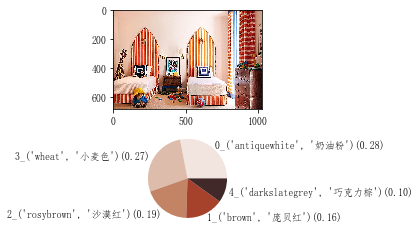

In [42]:
########## 显示图片
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False

plt.subplot(2, 1, 1)
plt.imshow(image)

plt.subplot(2, 1, 2)
plt.pie(Cluster_percentage, labels=LabelsShow, colors=Cluster_hex)
plt.show()

In [43]:
######## roi/ crop处理

In [44]:
import os,json, cv2
import webcolors
import numpy as np
from scipy.spatial import KDTree
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

In [45]:
def roi_color_detection(crop_cv2_mat, k = 3):
    resize_rate = 0.5
    w, h, c = crop_cv2_mat.shape
    H = int(resize_rate * h) if int(resize_rate * h) > 0 else h
    W = int(resize_rate * w) if int(resize_rate * w) > 0 else w
    modified_crop = cv2.resize(crop_cv2_mat, (H, W), interpolation=cv2.INTER_AREA)
    
    # modified_crop = crop_cv2_mat
    modified_crop = modified_crop.reshape(modified_crop.shape[0] * modified_crop.shape[1], 3)
    
    try:
        clf = KMeans(n_clusters = k)
        labels = clf.fit_predict(modified_crop)
        
    except ValueError:
        clf = KMeans(n_clusters = 1)
        labels = clf.fit_predict(modified_crop)
    
    counts = Counter(labels)
    center_colors = clf.cluster_centers_
    counts = dict(sorted(counts.items()))  ### 排序
    center_colors = clf.cluster_centers_
    
    
    
    

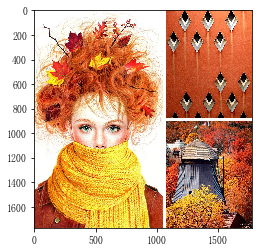

In [46]:
plt.imshow(image1)
plt.show()

In [40]:
def transparent_back(img):
    img = img.convert('RGBA')
    L, H = img.size
    color_0 = (0,0,0,0)#要替换的颜色
    for h in range(H):
        for l in range(L):
            dot = (l,h)
            color_1 = img.getpixel(dot)
            if color_1 == color_0:
                color_1 = color_1[:-1] + (0,)
                img.putpixel(dot,color_1)
    return img

import PIL.Image as Image
pil_img = Image.fromarray(cv2.cvtColor(image_src,cv2.COLOR_BGR2RGB)) #### opencv图像转化为PIL格式
new_img = transparent_back(pil_img)

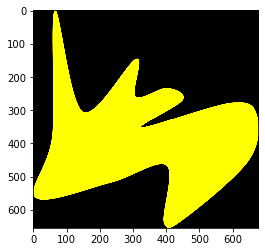

In [42]:
plt.imshow(new_img)
plt.show()

In [47]:
image_colour_cluster(image1, k = 5)

{'cluster_collocation': [('OrangeSeries', '橙色系'),
  ('GraySeries', '灰色系'),
  ('YellowSeries', '黄色系'),
  ('RedSeries', '红色系'),
  ('BrownSeries', '棕色系')],
 'k': 5,
 'rgb_percentage': [0.3672316384180791,
  0.20402821666826262,
  0.2038367008203262,
  0.12054326662197963,
  0.10436017747135243],
 'sorted_counts': [(2, 46020), (1, 25568), (3, 25544), (4, 15106), (0, 13078)],
 'sorted_hex': ['#bf5027', '#faf6ee', '#eeb13a', '#592822', '#d1b093'],
 'sorted_names': [('chocolate', '南瓜色'),
  ('whitesmoke', '亮白色'),
  ('goldenrod', '金色'),
  ('saddlebrown', '梅诺尔酒红'),
  ('tan', '米褐色')],
 'sorted_rgb': [(191, 80, 39),
  (250, 246, 238),
  (238, 177, 58),
  (89, 40, 34),
  (209, 176, 147)]}

In [1]:
img = Image.open("4.png")  # 读取照片
img = img.convert("RGBA")    # 转换格式，确保像素包含alpha通道
width, height = img.size     # 长度和宽度
for i in range(0,width):     # 遍历所有长度的点
    for j in range(0,height):       # 遍历所有宽度的点
        data = img.getpixel((i,j))  # 获取一个像素
        if (data.count(0) == 4):  # RGBA都是255，改成透明色
            img.putpixel((i,j),(255,255,255,0))

img.save("444.png")  


[ 0  0  0 ... -1 -1 -1]
92
Counter({-1: 965, 0: 22, 1: 11, 2: 8, 7: 8, 19: 7, 28: 6, 11: 5, 4: 4, 6: 4, 21: 4, 5: 3, 12: 3, 20: 3, 25: 3, 33: 3, 40: 3, 42: 3, 43: 3, 44: 3, 48: 3, 51: 3, 54: 3, 57: 3, 61: 3, 69: 3, 73: 3, 80: 3, 3: 2, 8: 2, 9: 2, 10: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 22: 2, 23: 2, 24: 2, 26: 2, 27: 2, 29: 2, 30: 2, 31: 2, 32: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 41: 2, 45: 2, 46: 2, 47: 2, 49: 2, 50: 2, 52: 2, 53: 2, 55: 2, 56: 2, 58: 2, 59: 2, 60: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 2, 70: 2, 71: 2, 72: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 81: 2, 82: 2, 83: 2, 84: 2, 85: 2, 86: 2, 87: 2, 88: 2, 89: 2, 90: 2, 91: 2})
93


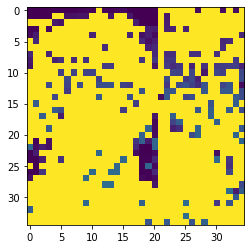

In [28]:
###### DBSCAN 聚类，没法拿到中心点数值

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN


img = cv2.imread('2.jpg')
resize_rate = 0.1
w, h, c = img.shape
H = int(resize_rate * h) if int(resize_rate * h) > 0 else h
W = int(resize_rate * w) if int(resize_rate * w) > 0 else w
modified_image = cv2.resize(img, (H, W), interpolation=cv2.INTER_AREA)


# modified_image= img
Z = np.float32(modified_image.reshape((-1,3)))

db = DBSCAN(eps=0.3, min_samples=2).fit(Z[:,:2])
labels = db.labels_  ## 聚类结果中-1表示没有聚类为离散点

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
counts = Counter(db.labels_)

print(db.labels_)
print(n_clusters_)
print(counts)
print(len(counts))


# plt.imshow(np.uint8(db.labels_.reshape(modified_image.shape[:2])))
# plt.show()

In [ ]:
########## hsv

In [1]:
%matplotlib inline
import cv2
from scipy.cluster.vq import vq, kmeans
from matplotlib import pyplot as plt
import numpy as np
import time as t

In [2]:
def do_cluster(hsv_image, K, channels):
    # gets height, width and the number of channes from the image shape
    h,w,c = hsv_image.shape
    # prepares data for clustering by reshaping the image matrix into a (h*w) x c matrix of pixels
    cluster_data = hsv_image.reshape( (h*w,c) )
    # grabs the initial time
    t0 = t.time()
    # performs clustering
    codebook, distortion = kmeans(np.array(cluster_data[:,0:channels], dtype=np.float), K)
    # takes the final time
    t1 = t.time()
    print ("Clusterization took %0.5f seconds" % (t1-t0))
    
    
    # calculates the total amount of pixels
    tot_pixels = h*w
    # generates clusters
    data, dist = vq(cluster_data[:,0:channels], codebook)
    # calculates the number of elements for each cluster
    weights = [len(data[data == i]) for i in range(0,K)]
    
    # creates a 4 column matrix in which the first element is the weight and the other three
    # represent the h, s and v values for each cluster
    color_rank = np.column_stack((weights, codebook))
    # sorts by cluster weight
    color_rank = color_rank[np.argsort(color_rank[:,0])]

    # creates a new blank image
    new_image =  np.array([0,0,255], dtype=np.uint8) * np.ones( (500, 500, 3), dtype=np.uint8)
    img_height = new_image.shape[0]
    img_width  = new_image.shape[1]

    # for each cluster
    for i,c in enumerate(color_rank[::-1]):
        
        # gets the weight of the cluster
        weight = c[0]
        
        # calculates the height and width of the bins
        height = int(weight/float(tot_pixels) *img_height )
        width = int(img_width/len(color_rank))

        # calculates the position of the bin
        x_pos = int(i*width)


        
        # defines a color so that if less than three channels have been used
        # for clustering, the color has average saturation and luminosity value
        color = np.array( [0,128,200], dtype=np.uint8)
        
        # substitutes the known HSV components in the default color
        for j in range(len(c[1:])):
            color[j] = c[j+1]
        
        # draws the bin to the image
        new_image[ img_height-height:img_height, x_pos:x_pos+width] = [color[0], color[1], color[2]]
        
    # returns the cluster representation
    return new_image

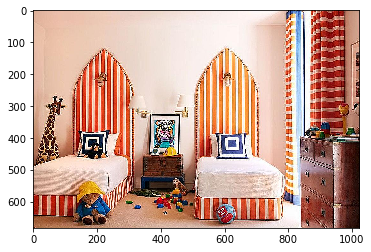

In [3]:
target_image = '5.jpg'
img = cv2.imread(target_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [4]:
hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [5]:
hue, sat, val = hsv_image[:,:,0], hsv_image[:,:,1], hsv_image[:,:,2]

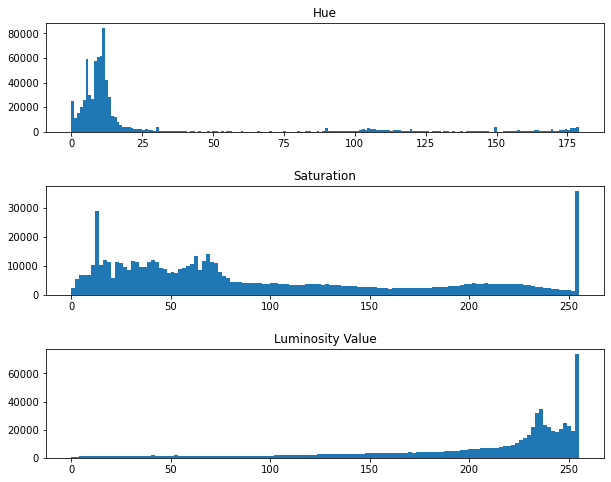

In [6]:
plt.figure(figsize=(10,8))
plt.subplot(311)                             #plot in the first cell
plt.subplots_adjust(hspace=.5)
plt.title("Hue")
plt.hist(np.ndarray.flatten(hue), bins=180)
plt.subplot(312)                             #plot in the second cell
plt.title("Saturation")
plt.hist(np.ndarray.flatten(sat), bins=128)
plt.subplot(313)                             #plot in the third cell
plt.title("Luminosity Value")
plt.hist(np.ndarray.flatten(val), bins=128)
plt.show()

Clusterization took 1.62962 seconds
Clusterization took 3.93248 seconds
Clusterization took 5.21204 seconds


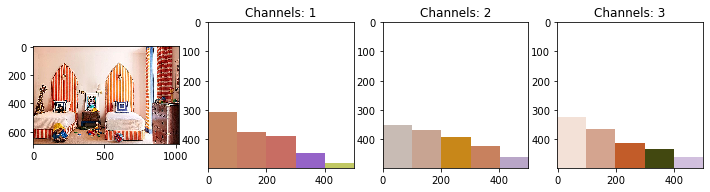

In [41]:
# creates a new figure size 12x10 inches
plt.figure(figsize=(12,10))
# creates a 4-column subplot
plt.subplot(141)
# in the first cell draws the target image
plt.imshow(img)

# calculates clusters for
# * h
# * h and s
# * h, s and v

for i in range(1,4):
    plt.subplot(141 + i)
    plt.title("Channels: %i" % i)
    new_image = do_cluster(hsv_image, 5, i)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    plt.imshow(new_image)
    
plt.show()

In [11]:
def do_cluster_v1(imgFile, K):
    
    target_image = imgFile
    img = cv2.imread(target_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # gets height, width and the number of channes from the image shape
    h,w,c = hsv_image.shape
    # prepares data for clustering by reshaping the image matrix into a (h*w) x c matrix of pixels
    cluster_data = hsv_image.reshape( (h*w,c) )
    # grabs the initial time
    t0 = t.time()
    # performs clustering
    codebook, distortion = kmeans(np.array(cluster_data[:,0:], dtype=np.float), K)
    # takes the final time
    t1 = t.time()
    print ("Clusterization took %0.5f seconds" % (t1-t0))
    
    
    # calculates the total amount of pixels
    tot_pixels = h*w
    # generates clusters
    data, dist = vq(cluster_data[:,0:], codebook)
    # calculates the number of elements for each cluster
    weights = [len(data[data == i]) for i in range(0,K)]
    
    # creates a 4 column matrix in which the first element is the weight and the other three
    # represent the h, s and v values for each cluster
    color_rank = np.column_stack((weights, codebook))
    # sorts by cluster weight
    color_rank = color_rank[np.argsort(color_rank[:,0])]
    
    # creates a new blank image
    new_image =  np.array([0,0,255], dtype=np.uint8) * np.ones( (500, 500, 3), dtype=np.uint8)
    img_height = new_image.shape[0]
    img_width  = new_image.shape[1]

    # for each cluster
    for i,c in enumerate(color_rank[::-1]):
        
        # gets the weight of the cluster
        weight = c[0]
        
        # calculates the height and width of the bins
        height = int(weight/float(tot_pixels) *img_height)
        width = int(img_width/len(color_rank))
        
        # calculates the position of the bin
        x_pos = int(i*width)
        
        # defines a color so that if less than three channels have been used
        # for clustering, the color has average saturation and luminosity value
        color = np.array( [0,128,200], dtype=np.uint8)
        
        # substitutes the known HSV components in the default color
        for j in range(len(c[1:])):
            color[j] = c[j+1]
            
            # tmp_hsv = tuple(color.tolist())
            # tmp_rgb = colorsys.hsv_to_rgb(tmp_hsv[0],tmp_hsv[1]/255.0,tmp_hsv[2]/255.0)
            # tmp_rgb = tuple(round(255*i) for i in tmp_rgb)
            # print(tmp_hsv, "hsv -- rgb  ", tmp_rgb)
        
        # draws the bin to the image
        
        # draws the bin to the image
        new_image[ img_height-height:img_height, x_pos:x_pos+width] = [color[0], color[1], color[2]]
        
    # returns the cluster representation
    return new_image

Clusterization took 4.41519 seconds


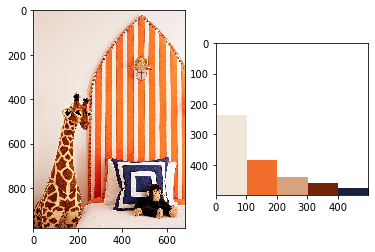

In [12]:
# creates a new figure size 12x10 inches


imgFile = "2.jpg"
img = cv2.imread(imgFile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)   
plt.imshow(img)


plt.subplot(122)
new_image = do_cluster_v1(imgFile, 5)
new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
plt.imshow(new_image)

plt.show()

In [9]:
############### 新方法：https://pypi.org/project/extcolors/#id3
import extcolors
import os,cv2,PIL

In [104]:
imgFile = "201811161542361479066046833.jpg"
img = cv2.imread(imgFile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
w,h,c = img.shape

In [12]:
colors, pixel_count = extcolors.extract_from_path(imgFile)
# colors, pixel_count =  extcolors.extract_from_image(PIL.Image.open(imgFile))
print(colors)
print(pixel_count)
print(sum(colors_dist))
print(w*h)

[((235, 235, 235), 136277), ((19, 19, 19), 106997), ((150, 146, 143), 17222), ((243, 205, 58), 7910), ((175, 162, 92), 1891), ((91, 80, 16), 1343), ((53, 121, 82), 1161), ((111, 29, 0), 212), ((41, 139, 166), 108), ((149, 85, 86), 72), ((218, 119, 28), 42), ((210, 53, 34), 31), ((250, 185, 157), 8), ((6, 65, 105), 3), ((177, 39, 99), 3)]
273280
273280
273280


In [14]:
def RGB2HEX(color):  ##### 颜色转化
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))


[ele[0] for ele in colors]

[(235, 235, 235),
 (19, 19, 19),
 (150, 146, 143),
 (243, 205, 58),
 (175, 162, 92),
 (91, 80, 16),
 (53, 121, 82),
 (111, 29, 0),
 (41, 139, 166),
 (149, 85, 86),
 (218, 119, 28),
 (210, 53, 34),
 (250, 185, 157),
 (6, 65, 105),
 (177, 39, 99)]

In [19]:
sorted_hex = [RGB2HEX(ele[0]) for ele in colors]
sorted_hex

['#ebebeb',
 '#131313',
 '#96928f',
 '#f3cd3a',
 '#afa25c',
 '#5b5010',
 '#357952',
 '#6f1d00',
 '#298ba6',
 '#955556',
 '#da771c',
 '#d23522',
 '#fab99d',
 '#064169',
 '#b12763']

In [17]:
sorted_counts = [(i,ele[1]) for i,ele in enumerate(colors)]
sorted_counts

[(0, 136277),
 (1, 106997),
 (2, 17222),
 (3, 7910),
 (4, 1891),
 (5, 1343),
 (6, 1161),
 (7, 212),
 (8, 108),
 (9, 72),
 (10, 42),
 (11, 31),
 (12, 8),
 (13, 3),
 (14, 3)]

In [18]:
sorted_rgb = [ele[0] for i,ele in enumerate(colors)]
sorted_rgb

[(235, 235, 235),
 (19, 19, 19),
 (150, 146, 143),
 (243, 205, 58),
 (175, 162, 92),
 (91, 80, 16),
 (53, 121, 82),
 (111, 29, 0),
 (41, 139, 166),
 (149, 85, 86),
 (218, 119, 28),
 (210, 53, 34),
 (250, 185, 157),
 (6, 65, 105),
 (177, 39, 99)]

In [22]:
sorted_names = [(colour_name_mapping(i)[:2]) for i in sorted_rgb]
sorted_names

[('beige', '棉花糖色'),
 ('black', '纯黑色'),
 ('grey', '素灰色'),
 ('gold', '毛茛花黄'),
 ('darkkhaki', '百灵鸟色'),
 ('darkolivegreen', '金峰石色'),
 ('darkolivegreen', '杜松子绿'),
 ('saddlebrown', '梅诺尔酒红'),
 ('darkcyan', '蓝鸟色'),
 ('dimgrey', '画眉鸟棕'),
 ('darkorange', '深干酪色'),
 ('crimson', '橘红色'),
 ('tan', '暗粉色'),
 ('midnightblue', '米克诺斯蓝'),
 ('crimson', '玫瑰红')]

In [25]:
rgb_percentage = [(ele[1]/pixel_count) for ele in sorted_counts]
rgb_percentage

[0.49867169203747075,
 0.3915288348946136,
 0.06301961358313818,
 0.028944672131147542,
 0.006919642857142857,
 0.0049143735362997655,
 0.004248389929742389,
 0.0007757611241217798,
 0.00039519906323185014,
 0.00026346604215456674,
 0.00015368852459016395,
 0.00011343676814988291,
 2.927400468384075e-05,
 1.0977751756440281e-05,
 1.0977751756440281e-05]

In [27]:
cluster_collocation = [Color2Collocation[ele[-1]] for ele in sorted_names]  ### 颜色色系，映射到居其家居
cluster_collocation = [(i, COLOR_COLLOCATION[i]) for i in cluster_collocation]
cluster_collocation

[('GraySeries', '灰色系'),
 ('GraySeries', '灰色系'),
 ('GraySeries', '灰色系'),
 ('YellowSeries', '黄色系'),
 ('BrownSeries', '棕色系'),
 ('BrownSeries', '棕色系'),
 ('GreenSeries', '绿色系'),
 ('RedSeries', '红色系'),
 ('BlueSeries', '蓝色系'),
 ('BrownSeries', '棕色系'),
 ('OrangeSeries', '橙色系'),
 ('RedSeries', '红色系'),
 ('PinkSeries', '粉色系'),
 ('BlueSeries', '蓝色系'),
 ('RedSeries', '红色系')]

In [28]:
Result = {
        "k": len(colors),
        "sorted_counts": sorted_counts,
        "sorted_rgb": sorted_rgb,
        "sorted_hex": sorted_hex,
        "sorted_names": sorted_names,
        "rgb_percentage": rgb_percentage,
        "cluster_collocation": cluster_collocation
    }



{'cluster_collocation': [('GraySeries', '灰色系'),
  ('GraySeries', '灰色系'),
  ('GraySeries', '灰色系'),
  ('YellowSeries', '黄色系'),
  ('BrownSeries', '棕色系'),
  ('BrownSeries', '棕色系'),
  ('GreenSeries', '绿色系'),
  ('RedSeries', '红色系'),
  ('BlueSeries', '蓝色系'),
  ('BrownSeries', '棕色系'),
  ('OrangeSeries', '橙色系'),
  ('RedSeries', '红色系'),
  ('PinkSeries', '粉色系'),
  ('BlueSeries', '蓝色系'),
  ('RedSeries', '红色系')],
 'k': 15,
 'rgb_percentage': [0.49867169203747075,
  0.3915288348946136,
  0.06301961358313818,
  0.028944672131147542,
  0.006919642857142857,
  0.0049143735362997655,
  0.004248389929742389,
  0.0007757611241217798,
  0.00039519906323185014,
  0.00026346604215456674,
  0.00015368852459016395,
  0.00011343676814988291,
  2.927400468384075e-05,
  1.0977751756440281e-05,
  1.0977751756440281e-05],
 'sorted_counts': [(0, 136277),
  (1, 106997),
  (2, 17222),
  (3, 7910),
  (4, 1891),
  (5, 1343),
  (6, 1161),
  (7, 212),
  (8, 108),
  (9, 72),
  (10, 42),
  (11, 31),
  (12, 8),
  (13, 3),
  

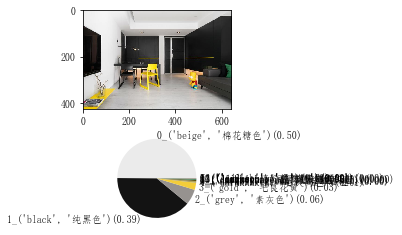

In [30]:
result = Result
Cluster_names = result["sorted_names"]
Cluster_percentage = result["rgb_percentage"]
Cluster_indexs = [ele[0] for ele in result["sorted_counts"]]
Cluster_hex = result["sorted_hex"]
LabelsShow = ["{}_{}({:.2f})".format(label, Cluster_names[i], Cluster_percentage[i]) for i, label in enumerate(Cluster_indexs)]

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False

plt.subplot(2, 1, 1)
plt.imshow(img)

plt.subplot(2, 1, 2)
plt.pie(Cluster_percentage, labels=LabelsShow, colors=Cluster_hex)
plt.show()

In [107]:
import extcolors

def image_extcolor(imgFile,k=5):
    #image = cv2.imread(imgFile)
    #image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    colors, pixel_count = extcolors.extract_from_path(imgFile)
    
    def RGB2HEX(color):  ##### 颜色转化
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))
    
    sorted_hex = [RGB2HEX(ele[0]) for ele in colors]
    sorted_counts = [(i,ele[1]) for i,ele in enumerate(colors)]
    sorted_rgb = [ele[0] for i,ele in enumerate(colors)]
    sorted_names = [(colour_name_mapping(i)[:2]) for i in sorted_rgb]
    rgb_percentage = [(ele[1]/pixel_count) for ele in sorted_counts]
    cluster_collocation = [Color2Collocation[ele[-1]] for ele in sorted_names]  ### 颜色色系，映射到居其家居
    cluster_collocation = [(i, COLOR_COLLOCATION[i]) for i in cluster_collocation]
    
    
    Result = {
        "k": k if len(colors)>=k else len(colors),
        "sorted_counts": sorted_counts[:k] if len(colors)>k else sorted_counts,
        "sorted_rgb": sorted_rgb[:k] if len(colors)>k else sorted_rgb,
        "sorted_hex": sorted_hex[:k] if len(colors)>k else sorted_hex,
        "sorted_names": sorted_names[:k] if len(colors)>k else sorted_names,
        "rgb_percentage": rgb_percentage[:k] if len(colors)>k else rgb_percentage,
        "cluster_collocation": cluster_collocation[:k] if len(colors)>k else cluster_collocation
    }
    
    return Result,colors
    

In [108]:

result,colors = image_extcolor(imgFile)

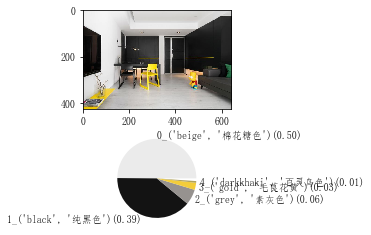

In [109]:
Cluster_names = result["sorted_names"]
Cluster_percentage = result["rgb_percentage"]
Cluster_indexs = [ele[0] for ele in result["sorted_counts"]]
Cluster_hex = result["sorted_hex"]
LabelsShow = ["{}_{}({:.2f})".format(label, Cluster_names[i], Cluster_percentage[i]) for i, label in enumerate(Cluster_indexs)]

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False

plt.subplot(2, 1, 1)
plt.imshow(img)

plt.subplot(2, 1, 2)
plt.pie(Cluster_percentage, labels=LabelsShow, colors=Cluster_hex)
plt.show()

In [41]:
def show_imgs(imgs):
    import math, cv2, os
    import matplotlib.pyplot as plt
    
    #### 确定行列
    num = len(imgs)
    rows = int(math.sqrt(num))
    cols = int(num / rows) + 1 if (num / rows) > int(num / rows) else int(num / rows)
    
    fig = plt.figure(figsize=(8, 8))
    for i in range(num):
        fig.add_subplot(rows, cols, i + 1)
        #img = cv2.imread(imgs[i])
        #label = os.path.basename(imgs[i])
        #plt.imshow(img[:, ::, ::-1]), plt.title(label), plt.axis('off')
    plt.show()

In [42]:
Cluster_hex

['#ebebeb', '#131313', '#96928f', '#f3cd3a', '#afa25c']

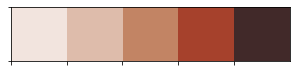

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt


def show_palette(hex_colors):
    sns.palplot(sns.color_palette(hex_colors))
    plt.show()

show_palette(Cluster_hex)

In [57]:
import math
from PIL import Image, ImageDraw

def image_result(colors, size):
    
    columns = 5
    width = int(min(len(colors), columns) * size)
    height = int((math.floor(len(colors) / columns) + 1) * size)

    result = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    canvas = ImageDraw.Draw(result)
    for idx, color in enumerate(colors):
        x = int((idx % columns) * size)
        y = int(math.floor(idx / columns) * size)
        canvas.rectangle([(x, y), (x + size - 1, y + size - 1)],
                         fill=color[0])
    
    plt.imshow(result)
    plt.show()

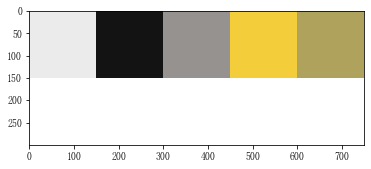

In [61]:
image_result(colors[:5], 150)

In [ ]:
############### 新的方法：https://pypi.org/project/dominant-color-detection/

In [142]:
from dominant_color_detection import detect_colors
k = 5
img_path = "201811161542361479066046833.jpg"

colors2, ratios2 = detect_colors(img_path, 10)

In [143]:
colors2

array(['#d4d2d0', '#111110', '#eaeaea', '#262523', '#bfbab4', '#3a3a36',
       '#a59d95', '#8d7f6f', '#5e5e55', '#e3c433'], dtype='<U7')

In [144]:
colors2 = [i for i in colors2]
colors2

['#d4d2d0',
 '#111110',
 '#eaeaea',
 '#262523',
 '#bfbab4',
 '#3a3a36',
 '#a59d95',
 '#8d7f6f',
 '#5e5e55',
 '#e3c433']

In [145]:
ratios2

array([0.19429025, 0.16437089, 0.13969412, 0.12372076, 0.12124794,
       0.09806743, 0.06287692, 0.03469938, 0.03075886, 0.03027344])

In [146]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

[webcolors.hex_to_rgb(i) for i in colors2]
#[hex_to_rgb(i) for i in a]

[(212, 210, 208),
 (17, 17, 16),
 (234, 234, 234),
 (38, 37, 35),
 (191, 186, 180),
 (58, 58, 54),
 (165, 157, 149),
 (141, 127, 111),
 (94, 94, 85),
 (227, 196, 51)]

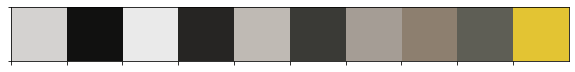

In [147]:
show_palette(['#d4d2d0',
 '#111110',
 '#eaeaea',
 '#262523',
 '#bfbab4',
 '#3a3a36',
 '#a59d95',
 '#8d7f6f',
 '#5e5e55',
 '#e3c433'])

In [100]:
################ 新方法：https://www.aiuai.cn/aifarm1158.html
from colorthief import ColorThief

def RGB2HEX(color):  ##### 颜色转化
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))
    
color_thief = ColorThief(img_path)

# get the dominant color
dominant_color = color_thief.get_color(quality=1) ##(r, g, b)
print(dominant_color)

# build a color palette
palette = color_thief.get_palette(color_count=10)
hex_color = [RGB2HEX(i) for i in palette] 
print(palette)

#### 

(35, 35, 33)
[(34, 34, 32), (214, 212, 210), (203, 174, 54), (95, 81, 73), (125, 121, 118), (156, 142, 134), (194, 174, 133), (167, 164, 161), (44, 153, 158)]


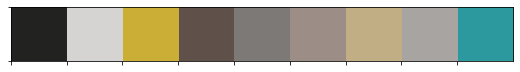

In [101]:
show_palette(hex_color)

In [110]:
colors

[((235, 235, 235), 136277),
 ((19, 19, 19), 106997),
 ((150, 146, 143), 17222),
 ((243, 205, 58), 7910),
 ((175, 162, 92), 1891),
 ((91, 80, 16), 1343),
 ((53, 121, 82), 1161),
 ((111, 29, 0), 212),
 ((41, 139, 166), 108),
 ((149, 85, 86), 72),
 ((218, 119, 28), 42),
 ((210, 53, 34), 31),
 ((250, 185, 157), 8),
 ((6, 65, 105), 3),
 ((177, 39, 99), 3)]

In [123]:
############ 冷暖色

def simple_warm_cold_color(colors):
    
    warm_colors = []
    cold_colors = []
    
    for c in colors:
        r,g,b = c[0]
        
        if b > r:
            color = 'cold' 
            cold_colors.append(c)
            
        else:
            color = 'warm'
            warm_colors.append(c)
            
        
        
    warm_colors_sorted = sorted(warm_colors, key=lambda x: x[1], reverse=True)
    cold_colors_sorted = sorted(cold_colors, key=lambda x: x[1], reverse=True)
    
    #print(warm_colors_sorted)
    #print(cold_colors_sorted)
    
    warm_index = [colors.index(ele) for ele in warm_colors_sorted if ele in colors]
    cold_inde = [colors.index(ele) for ele in cold_colors_sorted if ele in colors]
    print("warm_index:",warm_index)
    print("cold_inde:",cold_inde)
    
    return warm_colors_sorted,cold_colors_sorted
        

warm_colors, cold_colors = simple_warm_cold_color(colors)



warm_index: [0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 14]
cold_inde: [6, 8, 13]


In [124]:
warm_hexs = [RGB2HEX(ele[0]) for ele in warm_colors]
cold_hexs = [RGB2HEX(ele[0]) for ele in cold_colors]
print("暖色：{}, 冷色：{}".format(len(warm_hexs), len(cold_hexs)))

暖色：12, 冷色：3


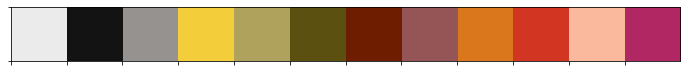

In [125]:
show_palette(warm_hexs)

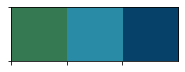

In [122]:
show_palette(cold_hexs)

In [148]:
def simple_warm_cold_color(colors):
	warm_colors = []
	cold_colors = []
	
	for c in colors:
		r, g, b = c[0]
		if b > r:
			color = 'cold'
			cold_colors.append(c)
		
		else:
			color = 'warm'
			warm_colors.append(c)
	
	warm_colors_sorted = sorted(warm_colors, key=lambda x: x[1], reverse=True)
	cold_colors_sorted = sorted(cold_colors, key=lambda x: x[1], reverse=True)
	warm_index = [colors.index(ele) for ele in warm_colors_sorted if ele in colors]
	cold_inde = [colors.index(ele) for ele in cold_colors_sorted if ele in colors]
	print("warm_index:", warm_index)
	print("cold_inde:", cold_inde)
	
	return warm_colors_sorted, cold_colors_sorted

In [154]:
def result_view2(extcolor_colors, imgFile, is_save=False):
	def view_image_color(extcolor_colors, size=10):
		import math
		from PIL import Image, ImageDraw
		columns = 5
		width = int(min(len(extcolor_colors), columns) * size)
		height = int((math.floor(len(extcolor_colors) / columns) + 1) * size)
		
		result = Image.new("RGBA", (width, height), (0, 0, 0, 0))
		canvas = ImageDraw.Draw(result)
		for idx, color in enumerate(extcolor_colors):
			x = int((idx % columns) * size)
			y = int(math.floor(idx / columns) * size)
			canvas.rectangle([(x, y), (x + size - 1, y + size - 1)], fill=color[0])
		
		return result
	
	image = cv2.imread(imgFile)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.subplot(4, 1, 1)
	plt.imshow(image),plt.axis('off')
	
	plt.subplot(4, 1, 2)
	color_extract = view_image_color(extcolor_colors, size=10)
	plt.imshow(color_extract),plt.axis('off')
	
	warm_colors, cold_colors = simple_warm_cold_color(extcolor_colors)
	
	plt.subplot(4, 1, 3)
	if warm_colors:
		warm_plate = view_image_color(warm_colors, size=2)
		plt.imshow(warm_plate),plt.axis('off')
		
	plt.subplot(4, 1, 4)
	if cold_colors:
		cold_plate = view_image_color(cold_colors, size=2)
		plt.imshow(cold_plate),plt.axis('off')
	
	if is_save:
		save_dir = r'.\test_in\save_out'
		save_file = os.path.join(save_dir,os.path.basename(imgFile))
		plt.savefig(save_file)
	
	
	plt.show()
	plt.close()


In [151]:
import glob

test_imgs = glob.glob(r"E:\HongsenQu\2_project\2_projects\8_color_classifier\color_chart\test_in\imgs_in" + "/*")
print(len(test_imgs))
test_imgs

72


['E:\\HongsenQu\\2_project\\2_projects\\8_color_classifier\\color_chart\\test_in\\imgs_in\\201704191492582835290051816.jpg',
 'E:\\HongsenQu\\2_project\\2_projects\\8_color_classifier\\color_chart\\test_in\\imgs_in\\201704191492582908354078612.jpg',
 'E:\\HongsenQu\\2_project\\2_projects\\8_color_classifier\\color_chart\\test_in\\imgs_in\\201704191492582930821008741.jpg',
 'E:\\HongsenQu\\2_project\\2_projects\\8_color_classifier\\color_chart\\test_in\\imgs_in\\201704191492582962973093213.jpg',
 'E:\\HongsenQu\\2_project\\2_projects\\8_color_classifier\\color_chart\\test_in\\imgs_in\\201704191492584616310052934.jpg',
 'E:\\HongsenQu\\2_project\\2_projects\\8_color_classifier\\color_chart\\test_in\\imgs_in\\201704191492585152365008918.jpg',
 'E:\\HongsenQu\\2_project\\2_projects\\8_color_classifier\\color_chart\\test_in\\imgs_in\\201704191492585174831020864.jpg',
 'E:\\HongsenQu\\2_project\\2_projects\\8_color_classifier\\color_chart\\test_in\\imgs_in\\201704191492585199096043004.jpg',


1/72
warm_index: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14]
cold_inde: [0, 6, 12, 13]


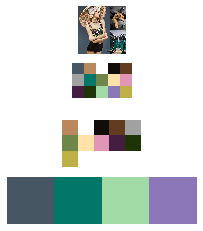

2/72
warm_index: [0, 2, 3, 5, 7, 8, 10, 11, 13]
cold_inde: [1, 4, 6, 9, 12]


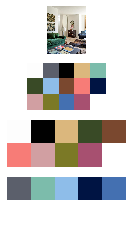

3/72
warm_index: [0, 2, 4, 6, 7, 9, 10]
cold_inde: [1, 3, 5, 8, 11, 12]


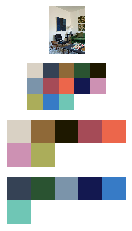

4/72
warm_index: [0, 1, 2, 4, 6, 7, 8, 10, 11, 12, 15, 17, 18, 19, 20]
cold_inde: [3, 5, 9, 13, 14, 16]


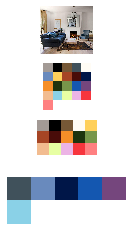

5/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
cold_inde: []


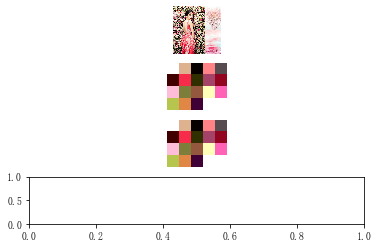

6/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]
cold_inde: [10]


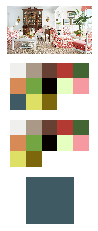

7/72
warm_index: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19]
cold_inde: [4, 12, 14]


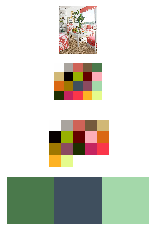

8/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 8]
cold_inde: [7]


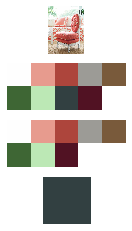

9/72
warm_index: [0, 1, 2, 3, 4, 6, 7, 9, 11, 13, 14]
cold_inde: [5, 8, 10, 12]


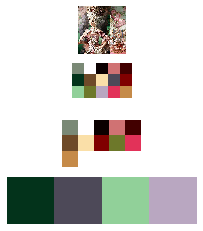

10/72
warm_index: [0, 2, 3, 4, 5, 6, 7, 12, 13, 14, 17, 18, 19]
cold_inde: [1, 8, 9, 10, 11, 15, 16, 20, 21]


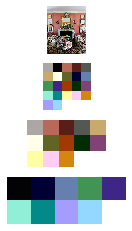

11/72
warm_index: [0, 1, 2, 3, 4, 5, 7, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 28]
cold_inde: [6, 8, 9, 10, 11, 13, 23, 24, 26, 27]


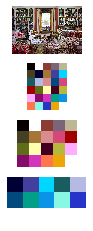

12/72
warm_index: [1, 3, 4, 5, 7, 10, 11, 12, 13, 15, 16, 18, 20, 21, 22, 25]
cold_inde: [0, 2, 6, 8, 9, 14, 17, 19, 23, 24]


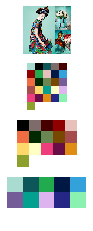

13/72
warm_index: [1, 2, 3, 4, 5, 6, 8, 10, 13, 14, 16, 19]
cold_inde: [0, 7, 9, 11, 12, 15, 17, 18, 20, 21]


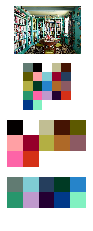

14/72
warm_index: [0, 3, 4, 5, 6, 9, 11, 12, 13, 14, 16, 17, 18]
cold_inde: [1, 2, 7, 8, 10, 15, 19]


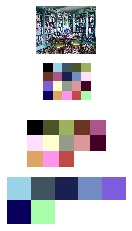

15/72
warm_index: [3, 6, 7, 8, 9]
cold_inde: [0, 1, 2, 4, 5]


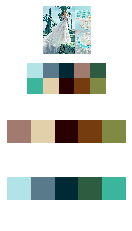

16/72
warm_index: [3, 5, 6, 7, 9, 10, 11, 12, 13]
cold_inde: [0, 1, 2, 4, 8]


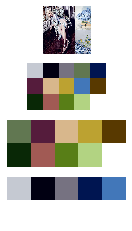

17/72
warm_index: [0, 2, 3, 5, 7, 9, 10]
cold_inde: [1, 4, 6, 8]


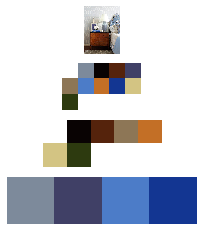

18/72
warm_index: [0, 1, 2, 3, 4, 8]
cold_inde: [5, 6, 7]


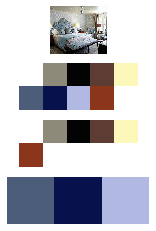

19/72
warm_index: [1, 2, 3, 5, 8]
cold_inde: [0, 4, 6, 7]


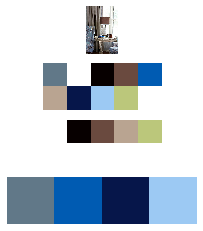

20/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7, 8]
cold_inde: []


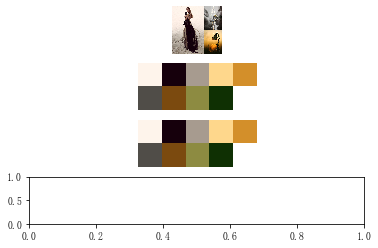

21/72
warm_index: [0, 1, 3, 4, 5, 6, 7]
cold_inde: [2]


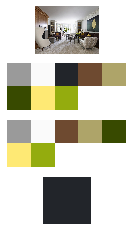

22/72
warm_index: [0, 1, 2, 3, 4, 5, 6]
cold_inde: [7, 8]


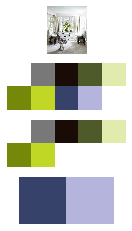

23/72
warm_index: [0, 1, 4, 5, 6, 7, 8, 11, 12, 13]
cold_inde: [2, 3, 9, 10]


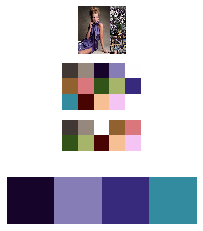

24/72
warm_index: [0, 1, 3, 5, 6, 7, 8, 9, 12, 13, 14, 18, 19, 20]
cold_inde: [2, 4, 10, 11, 15, 16, 17]


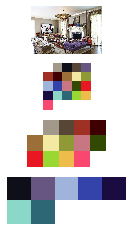

25/72
warm_index: [0, 1, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 21]
cold_inde: [2, 4, 9, 14, 17, 18, 19, 20, 22]


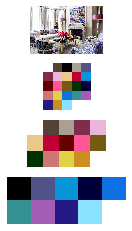

26/72
warm_index: [2, 3, 4, 5, 6, 8, 10, 15, 16, 17, 18, 22, 24]
cold_inde: [0, 1, 7, 9, 11, 12, 13, 14, 19, 20, 21, 23]


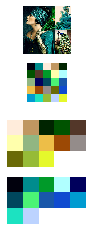

27/72
warm_index: [0, 2, 3, 4, 5, 6, 8, 9, 10]
cold_inde: [1, 7]


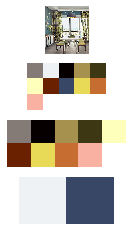

28/72
warm_index: [2, 3, 4, 5, 6, 7, 10]
cold_inde: [0, 1, 8, 9]


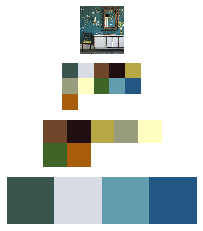

29/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17]
cold_inde: [12, 15, 16]


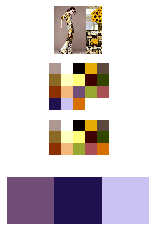

30/72
warm_index: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10]
cold_inde: [6, 11]


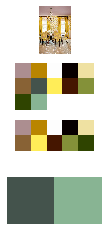

31/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13]
cold_inde: [10, 12]


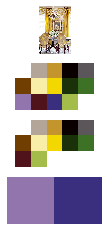

32/72
warm_index: [0, 1, 2, 3, 4, 5, 8]
cold_inde: [6, 7]


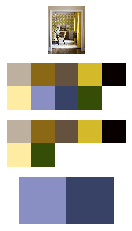

33/72
warm_index: [2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20]
cold_inde: [0, 1, 3, 6, 12, 17, 19]


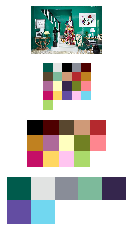

34/72
warm_index: [1, 3, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 19, 23]
cold_inde: [0, 2, 6, 8, 14, 17, 18, 20, 21, 22, 24]


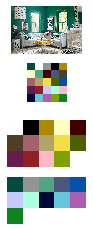

35/72
warm_index: [0, 3, 6, 7, 9, 10, 13, 14, 16, 17]
cold_inde: [1, 2, 4, 5, 8, 11, 12, 15]


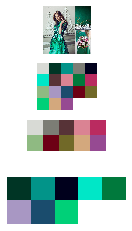

36/72
warm_index: [0, 1, 2, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18]
cold_inde: [3, 4, 10, 11, 12, 17, 19]


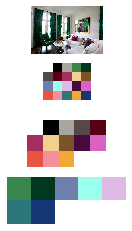

37/72
warm_index: [0, 2, 4, 6, 7, 8, 9, 10, 12, 14, 15, 17]
cold_inde: [1, 3, 5, 11, 13, 16, 18]


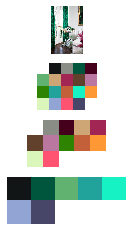

38/72
warm_index: [1, 2, 4, 5, 6, 7, 8]
cold_inde: [0, 3, 9]


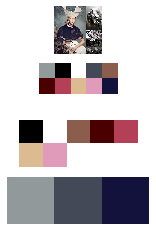

39/72
warm_index: [0, 1, 3, 4, 5, 6, 8, 9, 11]
cold_inde: [2, 7, 10]


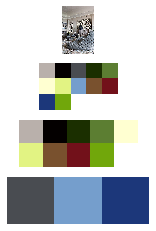

40/72
warm_index: [0, 1, 2, 4, 5, 6, 7, 9, 11, 12, 13]
cold_inde: [3, 8, 10]


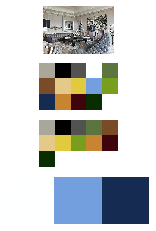

41/72
warm_index: [0, 1, 2, 4, 5, 7]
cold_inde: [3, 6]


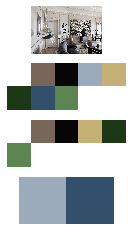

42/72
warm_index: [0]
cold_inde: [1, 2]


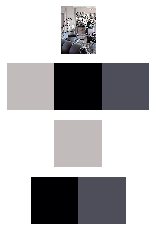

43/72
warm_index: [0, 1, 2, 3]
cold_inde: []


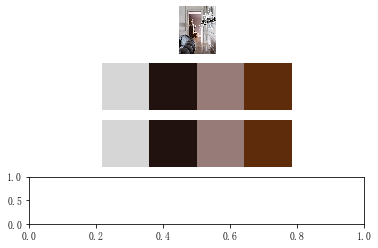

44/72
warm_index: [0, 1, 2, 3, 4, 5]
cold_inde: []


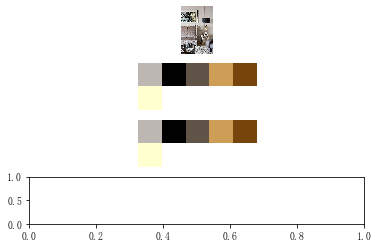

45/72
warm_index: [0, 1, 2, 3, 4, 5, 6]
cold_inde: []


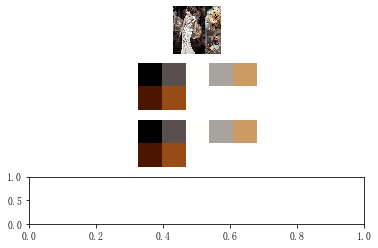

46/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cold_inde: []


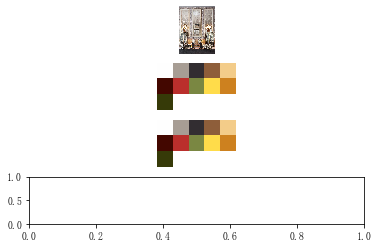

47/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7, 8]
cold_inde: []


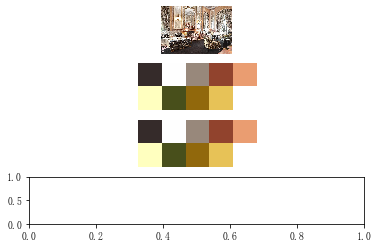

48/72
warm_index: [2, 3, 6, 8, 9, 10]
cold_inde: [0, 1, 4, 5, 7, 11]


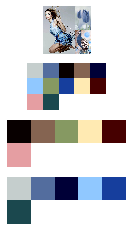

49/72
warm_index: [0, 1, 2, 5, 6]
cold_inde: [3, 4, 7, 8, 9]


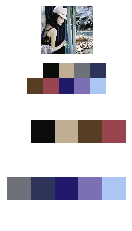

50/72
warm_index: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13]
cold_inde: [2, 8, 9]


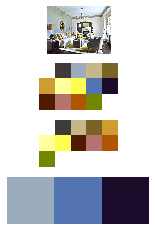

51/72
warm_index: [0, 3, 5, 6, 7, 8, 9, 15, 17, 19, 20, 22, 23, 24, 25]
cold_inde: [1, 2, 4, 10, 11, 12, 13, 14, 16, 18, 21]


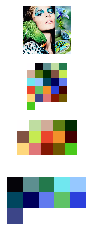

52/72
warm_index: [0, 1, 2, 4, 6, 7, 11, 13, 14, 16]
cold_inde: [3, 5, 8, 9, 10, 12, 15]


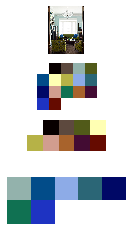

53/72
warm_index: [1, 2, 4, 5, 7, 8, 9, 10, 15, 17, 20, 21, 22, 24]
cold_inde: [0, 3, 6, 11, 12, 13, 14, 16, 18, 19, 23]


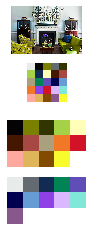

54/72
warm_index: [0, 1, 2, 4, 7, 8, 9, 11, 12, 15, 17, 18]
cold_inde: [3, 5, 6, 10, 13, 14, 16]


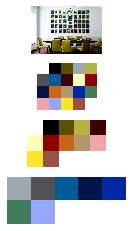

55/72
warm_index: [3, 4, 5, 6, 7, 8]
cold_inde: [0, 1, 2]


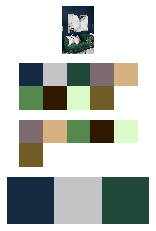

56/72
warm_index: [0, 2, 4, 5, 6, 7, 8, 9, 12, 14, 15]
cold_inde: [1, 3, 10, 11, 13]


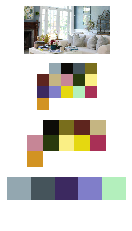

57/72
warm_index: [0, 3, 4, 5, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18]
cold_inde: [1, 2, 8, 10, 12, 19]


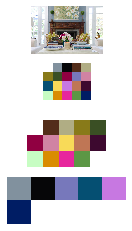

58/72
warm_index: [0, 2, 3, 4, 5, 6, 8, 10, 11, 12]
cold_inde: [1, 7, 9]


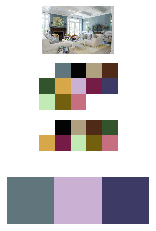

59/72
warm_index: [0, 1, 3, 4, 5, 8, 9, 10, 12, 13]
cold_inde: [2, 6, 7, 11]


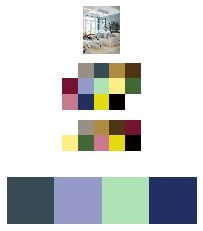

60/72
warm_index: [0, 1, 2, 3, 5, 7, 8, 10, 11, 13, 14, 15]
cold_inde: [4, 6, 9, 12, 16, 17, 18]


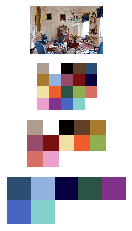

61/72
warm_index: [2, 4, 5, 6, 7, 8, 10]
cold_inde: [0, 1, 3, 9]


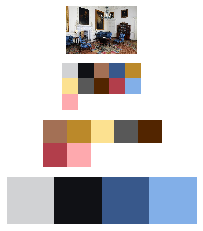

62/72
warm_index: [0, 1, 2, 3, 6, 7, 8, 9, 11, 13]
cold_inde: [4, 5, 10, 12]


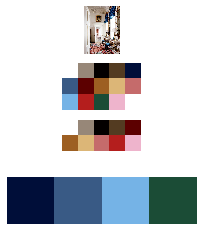

63/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7]
cold_inde: []


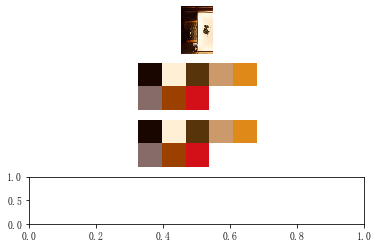

64/72
warm_index: [0, 2, 3, 4, 5, 6]
cold_inde: [1, 7]


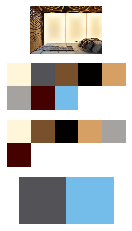

65/72
warm_index: [0, 1, 3, 4, 5, 6, 7]
cold_inde: [2, 8]


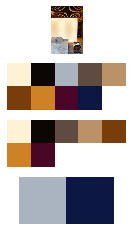

66/72
warm_index: [0, 1, 2, 3, 4, 5, 6, 7]
cold_inde: []


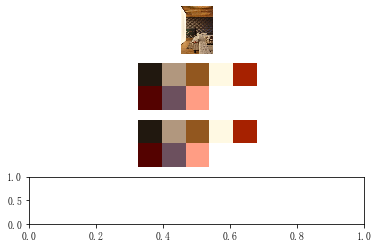

67/72
warm_index: [0, 1, 2, 3, 4, 6, 10]
cold_inde: [5, 7, 8, 9]


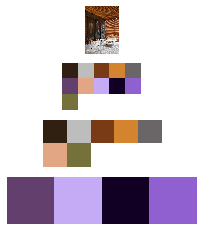

68/72
warm_index: [0, 1, 2, 3, 4, 6, 7, 9]
cold_inde: [5, 8, 10]


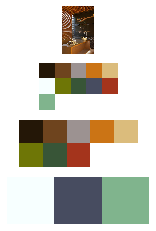

69/72
warm_index: [1, 5, 6, 8, 11, 12, 13, 14, 15, 18, 19]
cold_inde: [0, 2, 3, 4, 7, 9, 10, 16, 17]


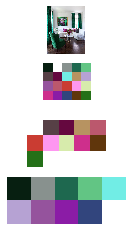

70/72
warm_index: [0, 1, 2, 5, 6, 7, 8, 9, 11, 12]
cold_inde: [3, 4, 10]


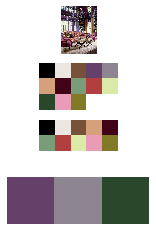

71/72
warm_index: [0, 1, 2, 5, 6, 8, 9, 11, 12, 14]
cold_inde: [3, 4, 7, 10, 13]


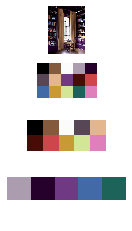

72/72
warm_index: [0, 1, 3, 4, 5, 6]
cold_inde: [2, 7]


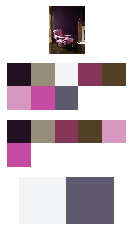

In [155]:

for i,img_file in enumerate(test_imgs):
    print("{}/{}".format(i + 1, len(test_imgs)))
    result,ex_colors = image_extcolor(img_file)
    
    hex_colors = result['sorted_hex']
    num_color = result['k']
    
    #print(colors)
    extract_color = ex_colors[:num_color]
    #print(extract_color)
    result_view2(ex_colors,img_file,True)

In [156]:
########## 将颜色映射到家居色

file = open("./ColourIndex.json", "r")
DICT = json.load(file)
file.close()



In [157]:
DICT

{'BlueSeries': {'collocation': 'BlueSeries',
  'color_data': [{'name_cn': 'Tiffany蓝',
    'raw_code': 'BU 6-01',
    'rbg_hex': '#85dbd8',
    'rgb_value': [133, 219, 216]},
   {'name_cn': '代尔夫特蓝',
    'raw_code': 'BU 2-06',
    'rbg_hex': '#3a5b8e',
    'rgb_value': [58, 91, 142]},
   {'name_cn': '勿忘我蓝',
    'raw_code': 'BU 3-01',
    'rbg_hex': '#8eafc2',
    'rgb_value': [142, 175, 194]},
   {'name_cn': '婴儿蓝',
    'raw_code': 'BU 2-01',
    'rbg_hex': '#b7cad9',
    'rgb_value': [183, 202, 217]},
   {'name_cn': '孔雀蓝',
    'raw_code': 'BU 5-05',
    'rbg_hex': '#007d93',
    'rgb_value': [0, 125, 147]},
   {'name_cn': '宁静蓝',
    'raw_code': 'BU 2-03',
    'rbg_hex': '#91a8d1',
    'rgb_value': [145, 168, 209]},
   {'name_cn': '挪威蓝',
    'raw_code': 'BU 4-02',
    'rbg_hex': '#4fa9cc',
    'rgb_value': [79, 169, 204]},
   {'name_cn': '摩洛哥蓝',
    'raw_code': 'BU 4-05',
    'rbg_hex': '#1c4f6a',
    'rgb_value': [28, 79, 106]},
   {'name_cn': '景泰蓝',
    'raw_code': 'BU 4-03',
    'rbg_h

In [169]:
RGB_COLORS_stand =  [(ele["rgb_value"], ele["rbg_hex"], ele["name_cn"]) for K, V in DICT.items() for ele in V['color_data']]
RGB_COLORS_stand

[([177, 143, 106], '#b18f6a', '冰咖啡色'),
 ([196, 169, 142], '#c4a98e', '古巴砂色'),
 ([198, 155, 100], '#c69b64', '太妃糖色'),
 ([98, 57, 61], '#62393d', '安道尔棕'),
 ([228, 199, 167], '#e4c7a7', '小麦色'),
 ([68, 55, 49], '#443731', '巧克力棕'),
 ([192, 186, 174], '#c0baae', '曙光银'),
 ([193, 174, 157], '#c1ae9d', '月光色'),
 ([172, 121, 78], '#ac794e', '杏仁色'),
 ([86, 67, 61], '#56433d', '栗色'),
 ([219, 208, 190], '#dbd0be', '沙色'),
 ([189, 153, 103], '#bd9967', '淡金色'),
 ([113, 92, 87], '#715c57', '深灰褐色'),
 ([164, 140, 127], '#a48c7f', '灰泥色'),
 ([172, 160, 146], '#aca092', '灰褐色'),
 ([210, 178, 155], '#d2b29b', '烤杏仁色'),
 ([118, 75, 58], '#764b3a', '玳瑁色'),
 ([145, 107, 84], '#916b54', '画眉鸟棕'),
 ([181, 154, 109], '#b59a6d', '百灵鸟色'),
 ([212, 183, 149], '#d4b795', '米褐色'),
 ([80, 54, 55], '#503637', '苦巧克力色'),
 ([113, 68, 65], '#714441', '貂皮色'),
 ([104, 72, 49], '#684831', '金峰石色'),
 ([145, 103, 43], '#91672b', '金棕色'),
 ([171, 150, 119], '#ab9677', '香薰色'),
 ([173, 129, 102], '#ad8166', '驼色'),
 ([111, 82, 66], '#6f5242'

In [367]:
def color_to_name(requested_rgb_colour):
    #### 居其家居颜色匹配，获取颜色英文名称
    EN_NAMES, EN_COLOURS = [], []
    WEB_DICT = webcolors.css3_hex_to_names 
    
    for hex_color,name in WEB_DICT.items():
        EN_NAMES.append(name)
        EN_COLOURS.append(webcolors.hex_to_rgb(hex_color))
    
    WB_SPACEDB = KDTree(EN_COLOURS)
    
    try:
        closest_en_name = webcolors.rgb_to_name(requested_rgb_colour)
    except ValueError:
        wb_dist, wb_index = WB_SPACEDB.query(requested_rgb_colour)
        closest_en_name = EN_NAMES[wb_index]
        # closest_wb_rgb = EN_COLOURS[wb_index]
    
    return closest_en_name

In [368]:
color_to_name((177, 143, 106))

'rosybrown'

In [1]:
import pandas as pd
from annoy import AnnoyIndex

In [174]:
df = pd.DataFrame(RGB_COLORS_stand, columns=['rgb_value', 'rbg_hex', 'name_cn'])
df

,rgb_value,rbg_hex,name_cn
0,"[177, 143, 106]",#b18f6a,冰咖啡色
1,"[196, 169, 142]",#c4a98e,古巴砂色
2,"[198, 155, 100]",#c69b64,太妃糖色
3,"[98, 57, 61]",#62393d,安道尔棕
4,"[228, 199, 167]",#e4c7a7,小麦色
5,"[68, 55, 49]",#443731,巧克力棕
6,"[192, 186, 174]",#c0baae,曙光银
7,"[193, 174, 157]",#c1ae9d,月光色
8,"[172, 121, 78]",#ac794e,杏仁色
9,"[86, 67, 61]",#56433d,栗色


In [370]:
RGB_COLORS_stand2 = [(ele["rgb_value"], ele["rbg_hex"], color_to_name(tuple(ele["rgb_value"])), ele["name_cn"]) for K, V in DICT.items() for ele in V['color_data']] 

df2 = pd.DataFrame(RGB_COLORS_stand2, columns=['rgb_value', 'rbg_hex','name_en', 'name_cn'])
df2

,rgb_value,rbg_hex,name_en,name_cn
0,"[177, 143, 106]",#b18f6a,rosybrown,冰咖啡色
1,"[196, 169, 142]",#c4a98e,tan,古巴砂色
2,"[198, 155, 100]",#c69b64,darkkhaki,太妃糖色
3,"[98, 57, 61]",#62393d,darkolivegreen,安道尔棕
4,"[228, 199, 167]",#e4c7a7,wheat,小麦色
5,"[68, 55, 49]",#443731,darkslategrey,巧克力棕
6,"[192, 186, 174]",#c0baae,silver,曙光银
7,"[193, 174, 157]",#c1ae9d,tan,月光色
8,"[172, 121, 78]",#ac794e,peru,杏仁色
9,"[86, 67, 61]",#56433d,darkolivegreen,栗色


In [189]:
f = len(df['rgb_value'][0])
f

3

In [212]:
len(df['rgb_value'])

189

In [190]:
t = AnnoyIndex(f, metric='euclidean')

In [191]:
ntree = 189
for i, vector in enumerate(df['rgb_value']):
    t.add_item(i, vector)
_ = t.build(ntree)

In [206]:
def get_similar_use_annoy2(rgb_vector):#### 按照向量进行相似度比较
    similar_indexs = t.get_nns_by_vector(rgb_vector, 3)
    similar_df = df.iloc[similar_indexs]
    #return rgb_value, name_cn, df.iloc[similar_rgbs]
    return similar_df

In [207]:
def get_similar_use_annoy(rgb_index):##### 按照索引进行相似度比较
    #rgb_value, rbg_hex, name_cn = df.iloc[rgb_index, [0, 1, 2]]
    similar_rgbs = t.get_nns_by_item(rgb_index, 3)
    #return rgb_value, name_cn, df.iloc[similar_rgbs]
    return df.iloc[similar_rgbs]

In [208]:
test_index = 0
df.iloc[test_index,[0, 1, 2]]

rgb_value    [177, 143, 106]
rbg_hex              #b18f6a
name_cn                 冰咖啡色
Name: 0, dtype: object

In [209]:
similar_df = get_similar_use_annoy(test_index)

In [210]:
similar_df

,rgb_value,rbg_hex,name_cn
0,"[177, 143, 106]",#b18f6a,冰咖啡色
18,"[181, 154, 109]",#b59a6d,百灵鸟色
25,"[173, 129, 102]",#ad8166,驼色


In [211]:
rgb_vector = [177, 143, 106]
get_similar_use_annoy2(rgb_vector)

,rgb_value,rbg_hex,name_cn
0,"[177, 143, 106]",#b18f6a,冰咖啡色
18,"[181, 154, 109]",#b59a6d,百灵鸟色
25,"[173, 129, 102]",#ad8166,驼色


In [217]:
def load_json(color_json):
    DICT = json.load(open(color_json, "r"))
    color_stand =  [(ele["rgb_value"], ele["rbg_hex"], ele["name_cn"]) for K, V in DICT.items() for ele in V['color_data']]
    df = pd.DataFrame(color_stand, columns=['rgb_value', 'rbg_hex', 'name_cn'])
    
    return df
    
def build_index(color_json,indexfile):
    DICT = json.load(open(color_json, "r"))
    color_stand =  [(ele["rgb_value"], ele["rbg_hex"], ele["name_cn"]) for K, V in DICT.items() for ele in V['color_data']]
    df = pd.DataFrame(color_stand, columns=['rgb_value', 'rbg_hex', 'name_cn'])
    
    f = len(df['rgb_value'][0]) ### 特征长度，即rgb值,为3
    t = AnnoyIndex(f, metric='euclidean')
    n_tree = len(df['rgb_value']) #### 要建立的分类树，一般为物体的种类个数，为189
    
    for i, vector in enumerate(df['rgb_value']):
        t.add_item(i, vector)
    _ = t.build(n_tree)
    
    t.save(indexfile)#### 保存索引文件
    if os.path.exists(indexfile):
        print("index build: done.")

    
indexfile = "./ColourIndex.tree"
if not os.path.exists(indexfile):   
    build_index("./ColourIndex.json", indexfile)

DATA = load_json("./ColourIndex.json")
INDEXER = AnnoyIndex(3, metric='euclidean')
INDEXER.load(indexfile)

True

In [3]:
INDEXER = AnnoyIndex(3, metric='euclidean')
indexfile = "./ColourIndex.tree"
INDEXER.load(indexfile)

True

In [4]:
INDEXER

In [220]:
#### 


ids = INDEXER.get_nns_by_vector(rgb_vector, 3)
a = DATA.iloc[ids]
a

,rgb_value,rbg_hex,name_cn
0,"[177, 143, 106]",#b18f6a,冰咖啡色
18,"[181, 154, 109]",#b59a6d,百灵鸟色
25,"[173, 129, 102]",#ad8166,驼色


In [229]:
def color_map(rgb_vector):
    num_similar = 1
    ids = INDEXER.get_nns_by_vector(rgb_vector, num_similar)
    df_similar = DATA.iloc[ids]
    Lists = np.array(df_similar).tolist()[0]
    
    return Lists

In [223]:
b = np.array(a).tolist()
b

[[[177, 143, 106], '#b18f6a', '冰咖啡色'],
 [[181, 154, 109], '#b59a6d', '百灵鸟色'],
 [[173, 129, 102], '#ad8166', '驼色']]

[[181, 154, 109], '#b59a6d', '百灵鸟色']

In [230]:
color_map(rgb_vector)

[[177, 143, 106], '#b18f6a', '冰咖啡色']

[((235, 235, 235), 136277),
 ((19, 19, 19), 106997),
 ((150, 146, 143), 17222),
 ((243, 205, 58), 7910),
 ((175, 162, 92), 1891),
 ((91, 80, 16), 1343),
 ((53, 121, 82), 1161),
 ((111, 29, 0), 212),
 ((41, 139, 166), 108),
 ((149, 85, 86), 72),
 ((218, 119, 28), 42),
 ((210, 53, 34), 31),
 ((250, 185, 157), 8),
 ((6, 65, 105), 3),
 ((177, 39, 99), 3)]

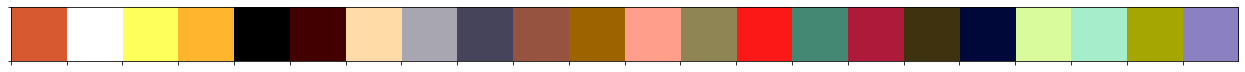

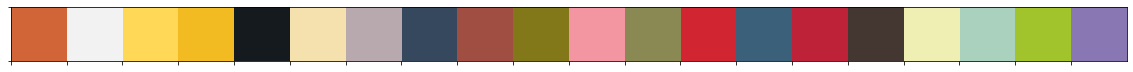

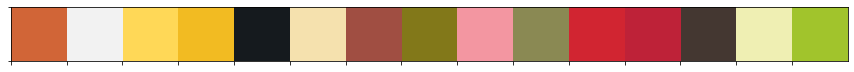

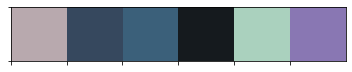

{0: 0.5178852004145355, 1: 0.38560157790927024, 2: 0.08788820913983887, 3: 0.008039982616253803, 4: 0.0003343028114866446, 5: 0.0001671514057433223, 6: 5.014542172299669e-05, 7: 3.343028114866446e-05}
[(242, 242, 242), '#f2f2f2', '亮白色']
[(139, 130, 115), '#8b8273', '岩石灰']
[(114, 37, 43), '#72252b', '梅诺尔酒红']
[(163, 55, 115), '#a33773', '紫红色']
[(235, 176, 206), '#ebb0ce', '粉丁香色']
[(21, 26, 30), '#151a1e', '纯黑色']
[(190, 34, 56), '#be2238', '中国红']
[(68, 55, 49), '#443731', '巧克力棕']
{0: 0.5178852004145355, 1: 0.38560157790927024, 2: 0.08788820913983887, 3: 0.008039982616253803, 4: 0.0003343028114866446, 5: 0.0001671514057433223, 6: 5.014542172299669e-05, 7: 3.343028114866446e-05}
{0: 0.5016553546003991, 1: 0.39779114513943287, 2: 0.0675636267990188, 3: 0.02957052268035932, 4: 0.0023786788040277436, 5: 0.0010120820872906505, 6: 2.2871911577189843e-05, 7: 5.717977894297461e-06}
[(21, 26, 30), '#151a1e', '纯黑色']
[(0, 100, 100), '#006464', '湖水绿']
[(1, 164, 181), '#01a4b5', '浅孔雀蓝']
[(195, 210, 191

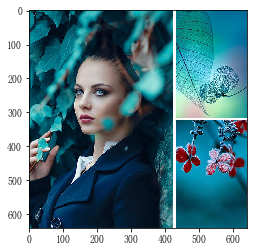

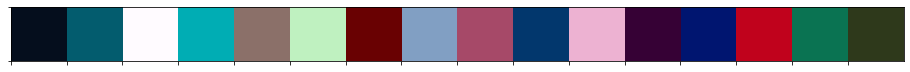

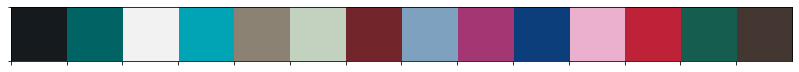

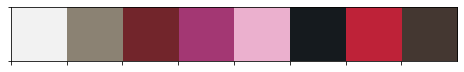

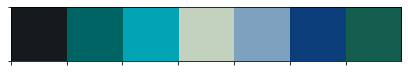

In [388]:
def image_color_extractor(imgFile,k=5):
    
    colors, pixel_count = extcolors.extract_from_path(imgFile)
    
    
    def RGB2HEX(color):
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))
    
    sorted_hex = [RGB2HEX(ele[0]) for ele in colors]
    sorted_rgb = [ele[0] for i,ele in enumerate(colors)]
    sorted_counts = [(i,ele[1]) for i,ele in enumerate(colors)]
    sorted_names = [(colour_name_mapping(i)[:2]) for i in sorted_rgb]
    
    rgb_percentage = [(ele[1]/pixel_count) for ele in sorted_counts]
    cluster_collocation = [Color2Collocation[ele[-1]] for ele in sorted_names]
    cluster_collocation = [(i, COLOR_COLLOCATION[i]) for i in cluster_collocation]
    
#     annoy_map = [color_map(list(c)) for c in sorted_rgb]
#     annoy_map = [[tuple(ele[0]), ele[1], ele[2]] for i,ele in enumerate(annoy_map)]
#     rgb_strand = [ele[0] for ele in annoy_map]
#     hex_strand = [ele[1] for ele in annoy_map]
#     name_cn = [ele[2] for ele in annoy_map]
    
    def get_map_color(colors):
        sorted_rgb = [ele[0] for i,ele in enumerate(colors)]
        annoy_map = [color_map(list(c)) for c in sorted_rgb]
        annoy_map = [[tuple(ele[0]), ele[1], ele[2]] for i,ele in enumerate(annoy_map)]
        
        color_fre = dict([i,ele[1]/sum([x[1] for x in colors])] for i,ele in enumerate(colors))
        print(color_fre)
        
        tmp_list = []
        indx = []
        tmp_rgb_fre = {}
        for i,ele in enumerate(annoy_map):
            print(ele)
            ix = annoy_map.index(ele)
            indx.append(ix)
            fre = color_fre.get(i)
            if ele not in tmp_list:
                tmp_list.append(ele)
                tmp_rgb_fre[ix] = fre
            else:
                print("重复：{} --->{}".format(tmp_rgb_fre[ix],fre))
                tmp_rgb_fre[ix] = tmp_rgb_fre[ix] + fre
            
        annoy_map = tmp_list
        print(tmp_rgb_fre)
        
        rgb_strand = [ele[0] for ele in annoy_map]
        hex_strand = [ele[1] for ele in annoy_map]
        name_cn = [ele[2] for ele in annoy_map]
        
        return hex_strand, name_cn
    
    def warm_cold(colors):
        warm_colors = []
        cold_colors = []
        for c in colors:
            r, g, b = c[0]
            if b > r:#color = 'cold'
                cold_colors.append(c)
            else:#color = 'warm'
                warm_colors.append(c)
        warm_colors_sorted = sorted(warm_colors, key=lambda x: x[1], reverse=True)
        cold_colors_sorted = sorted(cold_colors, key=lambda x: x[1], reverse=True)
        return warm_colors_sorted, cold_colors_sorted
        
    
        
    warms,colds = warm_cold(colors)
    warm_hex,w_n = get_map_color(warms)
    cold_hex,c_n = get_map_color(colds)
    
    m1_hex = sorted_hex#[:k]
    m2_hex,all_n = get_map_color(colors)#[:k]
    m3_hex = warm_hex#[:k]
    m4_hex = cold_hex#[:k]
    
#     print(all_n)
#     print(w_n)
#     print(c_n)
    
    return m1_hex,m2_hex,m3_hex,m4_hex

imgFile2 = "201709041504488579380064830.jpg"

m1, m2,m3,m4 = image_color_extractor(imgFile2)   
img = cv2.imread(imgFile2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

show_palette(m1)
show_palette(m2)
show_palette(m3)
show_palette(m4)

['鲨鱼灰', '亮白色', '中国红', '黄奶油色', '纯黑色', '草莓冰']
['亮白色', '中国红', '黄奶油色', '纯黑色', '草莓冰']
['鲨鱼灰']
['鲨鱼灰', '亮白色', '中国红', '黄奶油色', '纯黑色', '草莓冰']
['亮白色', '中国红', '黄奶油色', '纯黑色', '草莓冰']
['鲨鱼灰']


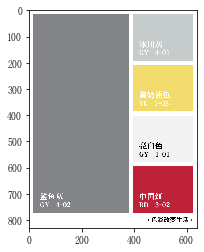

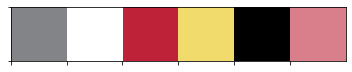

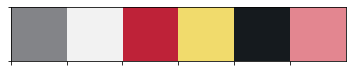

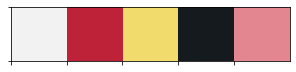

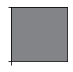

['亮白色', '金峰石色', '纯黑色', '含羞草花黄', '灰褐色', '青铜色', '古铜色', '柔玫瑰色', '经典绿', '帝王紫', '树梢绿', '金棕色', '粉黄色', '极光红', '帝国黄', '紫红色', '甜菜根色', '黄昏蓝', '火烈鸟粉', '粉丁香色', '草绿色']
['亮白色', '金峰石色', '纯黑色', '含羞草花黄', '灰褐色', '古铜色', '柔玫瑰色', '经典绿', '帝王紫', '树梢绿', '金棕色', '粉黄色', '极光红', '帝国黄', '甜菜根色', '火烈鸟粉']
['青铜色', '紫红色', '黄昏蓝', '粉丁香色', '草绿色']
['亮白色', '金峰石色', '纯黑色', '含羞草花黄', '灰褐色', '青铜色', '古铜色', '柔玫瑰色', '经典绿', '帝王紫', '树梢绿', '金棕色', '粉黄色', '极光红', '帝国黄', '紫红色', '甜菜根色', '黄昏蓝', '火烈鸟粉', '粉丁香色', '草绿色']
['亮白色', '金峰石色', '纯黑色', '含羞草花黄', '灰褐色', '古铜色', '柔玫瑰色', '经典绿', '帝王紫', '树梢绿', '金棕色', '粉黄色', '极光红', '帝国黄', '甜菜根色', '火烈鸟粉']
['青铜色', '紫红色', '黄昏蓝', '粉丁香色', '草绿色']


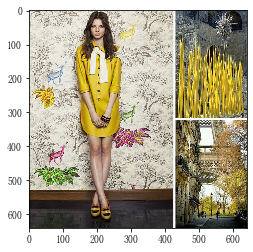

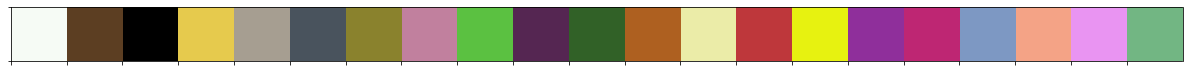

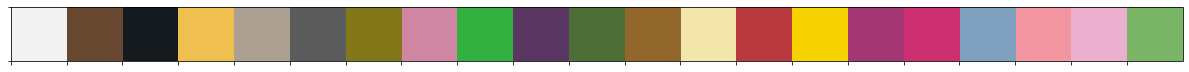

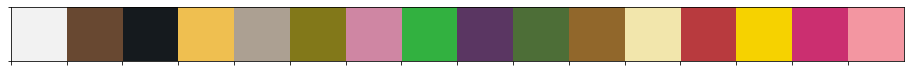

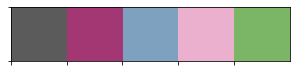

['冰川灰', '青铜色', '青柠色', '纯黑色', '巧克力棕', '砖红色', '百灵鸟色', '藏蓝', '花蕾红', '镉橘黄', '嫩黄色', '康乃馨粉', '佩斯利紫', '玫瑰红', '抹茶色', '葡萄紫色', '黄奶油色', '亮白色']
['冰川灰', '青铜色', '青柠色', '巧克力棕', '纯黑色', '砖红色', '百灵鸟色', '花蕾红', '镉橘黄', '嫩黄色', '康乃馨粉', '玫瑰红', '葡萄紫色', '黄奶油色', '亮白色']
['纯黑色', '藏蓝', '佩斯利紫', '抹茶色']
['冰川灰', '青铜色', '青柠色', '纯黑色', '巧克力棕', '砖红色', '百灵鸟色', '藏蓝', '花蕾红', '镉橘黄', '嫩黄色', '康乃馨粉', '佩斯利紫', '玫瑰红', '抹茶色', '葡萄紫色', '黄奶油色', '亮白色']
['冰川灰', '青铜色', '青柠色', '巧克力棕', '纯黑色', '砖红色', '百灵鸟色', '花蕾红', '镉橘黄', '嫩黄色', '康乃馨粉', '玫瑰红', '葡萄紫色', '黄奶油色', '亮白色']
['纯黑色', '藏蓝', '佩斯利紫', '抹茶色']


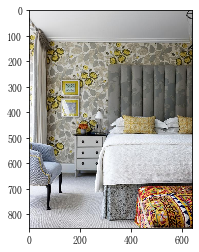

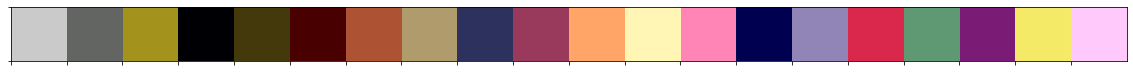

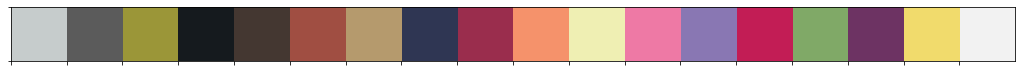

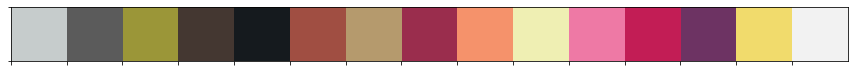

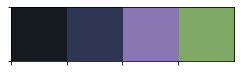

['魅影黑', '亮白色', '银色', '橄榄绿', '砖红色', '纯黑色']
['魅影黑', '亮白色', '橄榄绿', '砖红色', '纯黑色']
['银色']
['魅影黑', '亮白色', '银色', '橄榄绿', '砖红色', '纯黑色']
['魅影黑', '亮白色', '橄榄绿', '砖红色', '纯黑色']
['银色']


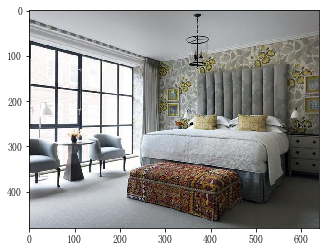

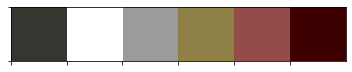

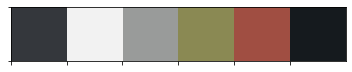

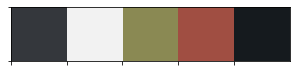

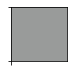

['亮白色', '烟灰色', '栗色', '青柠色', '巧克力棕', '纯黑色', '热粉红色', '番茄酱红', '嫩黄色', '金色', '帝王紫', '暗粉色', '佩斯利紫', '藏蓝', '玫瑰红', '葡萄紫色', '维多利亚蓝', '杜松子绿', '活力橙', '紫水晶色', '柠檬绿', '粉丁香色', '胭脂粉', '鸟蛋绿', '中国红', '毛茛花黄', '比斯开湾蓝']
['栗色', '青柠色', '巧克力棕', '纯黑色', '热粉红色', '番茄酱红', '嫩黄色', '金色', '暗粉色', '玫瑰红', '葡萄紫色', '活力橙', '柠檬绿', '粉丁香色', '胭脂粉', '中国红', '毛茛花黄']
['亮白色', '烟灰色', '帝王紫', '佩斯利紫', '藏蓝', '维多利亚蓝', '杜松子绿', '紫水晶色', '鸟蛋绿', '比斯开湾蓝']
['亮白色', '烟灰色', '栗色', '青柠色', '巧克力棕', '纯黑色', '热粉红色', '番茄酱红', '嫩黄色', '金色', '帝王紫', '暗粉色', '佩斯利紫', '藏蓝', '玫瑰红', '葡萄紫色', '维多利亚蓝', '杜松子绿', '活力橙', '紫水晶色', '柠檬绿', '粉丁香色', '胭脂粉', '鸟蛋绿', '中国红', '毛茛花黄', '比斯开湾蓝']
['栗色', '青柠色', '巧克力棕', '纯黑色', '热粉红色', '番茄酱红', '嫩黄色', '金色', '暗粉色', '玫瑰红', '葡萄紫色', '活力橙', '柠檬绿', '粉丁香色', '胭脂粉', '中国红', '毛茛花黄']
['亮白色', '烟灰色', '帝王紫', '佩斯利紫', '藏蓝', '维多利亚蓝', '杜松子绿', '紫水晶色', '鸟蛋绿', '比斯开湾蓝']


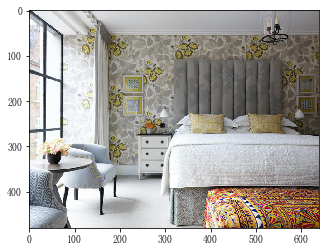

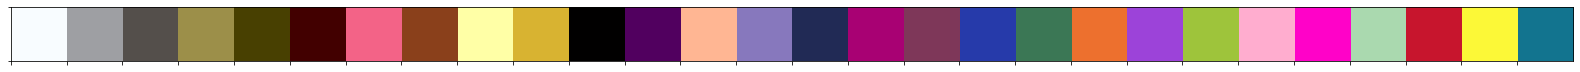

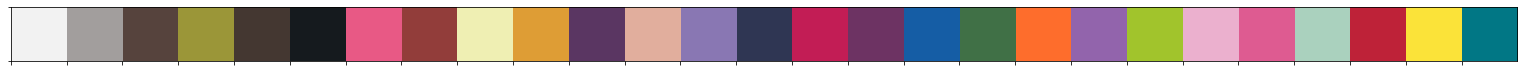

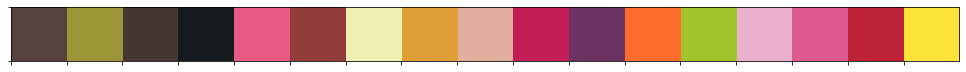

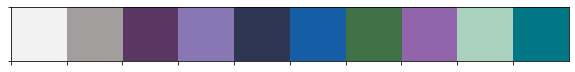

In [346]:
test_imgs = glob.glob(r"E:\HongsenQu\2_project\2_projects\8_color_classifier\color_chart\color9_new\灰色系\鲨鱼灰\心灵净土" + "/*")
for img_file_in in test_imgs:
    image_color_extractor(img_file_in)
    
    m1, m2,m3,m4 = image_color_extractor(img_file_in)
#     img = cv2.imread(img_file_in)
    img = cv2.imdecode(np.fromfile(img_file_in,dtype=np.uint8),cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    show_palette(m1)
    show_palette(m2)
    show_palette(m3)
    show_palette(m4)

In [329]:
imgFile2 = "201708091502242980278042102.jpg"
print(extcolors.extract_from_path(imgFile2))

([((246, 251, 245), 166504), ((92, 62, 34), 75108), ((0, 0, 0), 72015), ((230, 202, 77), 51220), ((166, 158, 145), 21687), ((73, 83, 93), 13927), ((138, 130, 45), 4775), ((193, 128, 158), 1601), ((91, 193, 65), 858), ((85, 38, 82), 478), ((49, 97, 39), 447), ((174, 96, 32), 393), ((235, 236, 168), 211), ((190, 55, 59), 147), ((231, 242, 16), 121), ((143, 47, 155), 77), ((190, 38, 115), 22), ((125, 152, 195), 4), ((244, 163, 134), 3), ((233, 148, 242), 1), ((114, 182, 131), 1)], 409600)


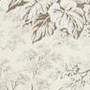

In [339]:
from PIL import Image

cv_img = cv2.imread(imgFile2)
cv_img = cv_img[10:100,10:100]
pil_img = Image.fromarray(cv2.cvtColor(cv_img,cv2.COLOR_BGR2RGB))
pil_img.convert("RGBA")


In [340]:
###### 读取图像
print(extcolors.extract_from_image(pil_img))

([((235, 233, 220), 7812), ((148, 140, 121), 288)], 8100)


In [390]:
# coding:utf-8
### package:
import extcolors,webcolors
import os,cv2,PIL,json
import numpy as np
from PIL import Image
import pandas as pd
from annoy import AnnoyIndex
from scipy.spatial import KDTree



########### 颜色配置信息

COLOR_COLLOCATION = {
        'BlueSeries': '蓝色系',
        'BrownSeries': '棕色系',
        'GraySeries': '灰色系',
        'GreenSeries': '绿色系',
        'OrangeSeries': '橙色系',
        'PinkSeries': '粉色系',
        'PurpleSeries': '紫色系',
        'RedSeries': '红色系',
        'YellowSeries': '黄色系'
}

jsonFile = './ColourIndex.json'
IndexFile = './ColourIndex.tree'


def color_to_name(requested_rgb_colour):
    #### 居其家居颜色匹配，获取颜色英文名称
    EN_NAMES, EN_COLOURS = [], []
    WEB_DICT =  webcolors.css3_hex_to_names #webcolors.CSS3_HEX_TO_NAMES

    for hex_color,name in WEB_DICT.items():
        EN_NAMES.append(name)
        EN_COLOURS.append(webcolors.hex_to_rgb(hex_color))

    WB_SPACEDB = KDTree(EN_COLOURS)

    try:
        closest_en_name = webcolors.rgb_to_name(requested_rgb_colour)
    except ValueError:
        wb_dist, wb_index = WB_SPACEDB.query(requested_rgb_colour)
        closest_en_name = EN_NAMES[wb_index]
        # closest_wb_rgb = EN_COLOURS[wb_index]

    return closest_en_name



def load_json():
    color_stand =  [(ele["rgb_value"], ele["rbg_hex"], color_to_name(tuple(ele["rgb_value"])), ele["name_cn"]) for K, V in DICT.items() for ele in V['color_data']]
    df = pd.DataFrame(color_stand, columns=['rgb_value', 'rbg_hex', 'name_en', 'name_cn'])
    return df


def build_index(color_json,indexfile):
    DICT = json.load(open(color_json, "r"))
    color_stand =  [(ele["rgb_value"], ele["rbg_hex"], color_to_name(tuple(ele["rgb_value"])), ele["name_cn"]) for K, V in DICT.items() for ele in V['color_data']]
    df = pd.DataFrame(color_stand, columns=['rgb_value', 'rbg_hex', 'name_en', 'name_cn'])

    f = len(df['rgb_value'][0]) ### 特征长度，即rgb值,为3
    t = AnnoyIndex(f, metric='euclidean')
    n_tree = len(df['rgb_value']) #### 要建立的分类树，一般为物体的种类个数，为189

    for i, vector in enumerate(df['rgb_value']):
        t.add_item(i, vector)
    _ = t.build(n_tree)

    t.save(indexfile)#### 保存索引文件
    if os.path.exists(indexfile):
        print("index build: done.")



if not os.path.exists(IndexFile):
    build_index(jsonFile, IndexFile)


def color_map(rgb_vector):
    num_similar = 1
    ids = INDEXER.get_nns_by_vector(rgb_vector, num_similar)
    df_similar = DATA.iloc[ids]
    Lists = np.array(df_similar).tolist()[0]

    return Lists


def image_color_extractor(cv_mat,k=5):

    img = Image.fromarray(cv2.cvtColor(cv_mat,cv2.COLOR_BGR2RGB))
    colors, pixel_count = extcolors.extract_from_image(img)

    def get_map_color(colors):
        sorted_rgb = [ele[0] for i,ele in enumerate(colors)]
        annoy_map = [color_map(list(c)) for c in sorted_rgb]
        annoy_map = [[tuple(ele[0]), ele[1], ele[2], ele[3]] for i,ele in enumerate(annoy_map)]

        color_fre = dict([i,ele[1]/sum([x[1] for x in colors])] for i,ele in enumerate(colors))
        #print(color_fre)

        tmp_list = []
        indx = []
        tmp_rgb_fre = {}
        for i,ele in enumerate(annoy_map):
            #print(ele)
            ix = annoy_map.index(ele)
            indx.append(ix)
            fre = color_fre.get(i)
            if ele not in tmp_list:
                tmp_list.append(ele)
                tmp_rgb_fre[ix] = fre
            else:
                tmp_rgb_fre[ix] = tmp_rgb_fre[ix] + fre

        annoy_map = tmp_list
        #print(tmp_rgb_fre)

        rgb_fre = [tmp_rgb_fre.get(i) for i in tmp_rgb_fre]
        rgb_standard = [ele[0] for ele in annoy_map] ### rgb list
        hex_standard = [ele[1] for ele in annoy_map]
        name_en = [ele[2] for ele in annoy_map]
        name_cn = [ele[3] for ele in annoy_map]

        return rgb_standard, hex_standard, name_en, name_cn, rgb_fre

    def warm_cold(colors):
        warm_colors = []
        cold_colors = []
        for c in colors:
            r, g, b = c[0]
            if b > r:#color = 'cold'
                cold_colors.append(c)
            else:#color = 'warm'
                warm_colors.append(c)
        warm_colors_sorted = sorted(warm_colors, key=lambda x: x[1], reverse=True)
        cold_colors_sorted = sorted(cold_colors, key=lambda x: x[1], reverse=True)
        return warm_colors_sorted, cold_colors_sorted


    # warms,colds = warm_cold(colors)
    # warm_rgbs,warm_hexs, warm_ne,warm_nc = get_map_color(warms)
    # cold_rgbs, cold_hexs, cold_ne, cold_nc = get_map_color(colds)


    rgb_list, hex_list, names_en, names_cn,rgb_fre = get_map_color(colors)



    Result = {
        "rgbs": rgb_list[:k] if len(rgb_list)>k else rgb_list,
        "hexs": hex_list[:k] if len(rgb_list)>k else hex_list,
        'names_en': names_en[:k] if len(rgb_list)>k else names_en,
        "names_cn": names_cn[:k] if len(rgb_list)>k else names_cn,
        "rgb_fre": rgb_fre[:k] if len(rgb_list)>k else rgb_fre
    }

    return Result



def test():
    imgfile = "2.jpg"
    im = cv2.imread(imgfile)[1:700,1:900]

    a = image_color_extractor(im)
    print(len(a))
    print(a)

##########
file = open(jsonFile, "r")
DICT = json.load(file)
file.close()

colorname2rgb = [(ele["name_cn"], ele["rgb_value"]) for K, V in DICT.items() for ele in V['color_data']]
Colorname2RGB = dict([ele[0], tuple(ele[1])] for ele in colorname2rgb)
color2collocation = [(ele["name_cn"], K) for K, V in DICT.items() for ele in V['color_data']]
Color2Collocation = dict([ele[0], ele[1]] for ele in color2collocation)

DATA = load_json()
INDEXER = AnnoyIndex(3, metric='euclidean')
INDEXER.load(IndexFile)


if __name__ == "__main__":
    test()

5
{'rgbs': [(243, 229, 220), (254, 109, 44), (114, 37, 43), (225, 174, 157), (21, 26, 30)], 'hexs': ['#f3e5dc', '#fe6d2c', '#72252b', '#e1ae9d', '#151a1e'], 'names_en': ['antiquewhite', 'tomato', 'saddlebrown', 'tan', 'black'], 'names_cn': ['奶油粉', '活力橙', '梅诺尔酒红', '暗粉色', '纯黑色'], 'rgb_fre': [0.632949811171366, 0.2953979435168836, 0.03297536535146423, 0.025327962766302833, 0.007463077351665316]}
